<a href="https://colab.research.google.com/github/MtHenriqueF/german-credit-risk-prediction/blob/main/german_credit_prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho aprendizado automático - como será feito


## Parte 1
 A partir da base de dados enviada e do estudo sobre pré-processamentos, apresentar os resultados obtidos, utilizando o modelo **Decision Tree (DT)**, e discutir seus resultados dentro dos processos para Data Mining.

<br>

1) A partir da base de dados:
a. Descreva a base de dados descrendo os atributos, numéricos e categóricos, classificando segundo a escala (nominal ou razão) e a cardinalidade (discreta,
contínua, binária).
b. Descreva cada um dos atributos segundo frequência, mínimo e máximo valor,
dia desvios padrão, conforme o caso.
c. Avalie os resultados dos processos abaixo, caso sejam utilizados na base de
dados, após o processo de classificação com DT ter sido utilizado.
i. limpeza de dados (outlier, missing)
ii. normalização/transformação
iii. discretização

<br>

2) Faça uma análise de seleção de variáveis utilizando os métodos que julgar necessários, considerando o tipo de dado. Abaixo uma tabela é indicada para que possa usar como inspiração avaliação de importância composta dos métodos que considerar.
Dica: utilize uma tabela métodos x ranking com atributos selecionados.

|Método de seleção 1|Método de seleção 2|Método de seleção 3|Método de seleção 4|
--------------------|-------------------|-------------------|------------------|
| Atributo 1| | | |
| Atributo 2| | | |
| Atributo 3| | | |
| ... | | | |
| Atributo n| | | |

## Parte 2

A partir da base de dados enviada e do estudo sobre pré-processamentos feitos na primeira
parte do trabalho (corrigindo os problemas identificados na avaliação e a execução da
seleção de variáveis para os que não avaliaram), apresentar novos resultados utilizando o
modelo Decision Tree (DT), kNN e Naive Bayes e acrescente um outro algoritmo (pode
ser ensemble ou redes neural, por exemplo) e discutir seus resultados, seguindo os
processos para Data Mining.

---
# Montando drive

In [152]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
import os

# Caminho específico para a pasta do seu projeto
WORKDIR = '/content/drive/My Drive/data-science/data_science_avaliacoes'

os.chdir(WORKDIR)
print('Diretório atual:', os.getcwd())


Diretório atual: /content/drive/My Drive/data-science/data_science_avaliacoes


---
# Lendo dataset

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [155]:
X = pd.read_csv('class_german_credit.csv')

In [156]:
X.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [157]:
y = X['Risk']
y.head()

,Risk
0,good
1,bad
2,good
3,good
4,bad


---
# Caso base (Baseline) - Ínicio da parte 1 do trabalho


Antes de aplicar qualquer pré-processamento avançado, vamos remover apenas os missing values e treinar o modelo inicial. Esse caso base (baseline) servirá como referência para avaliar a eficácia das técnicas de pré-processamento que serão testadas posteriormente.

### Estratificando a base e ajustando tipos de atributos

In [158]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=0)

In [159]:
X_train.drop('Risk', axis=1, inplace=True)
X_test.drop('Risk', axis=1, inplace=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 355 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    int64 
 1   Sex               800 non-null    object
 2   Job               800 non-null    int64 
 3   Housing           800 non-null    object
 4   Saving accounts   657 non-null    object
 5   Checking account  486 non-null    object
 6   Credit amount     800 non-null    int64 
 7   Duration          800 non-null    int64 
 8   Purpose           800 non-null    object
dtypes: int64(4), object(5)
memory usage: 62.5+ KB


In [160]:
X_train.describe()

,Age,Job,Credit amount,Duration
count,800.000000,800.000000,800.000000,800.000000
mean,35.438750,1.895000,3247.860000,20.916250
std,11.475991,0.645752,2775.170745,11.997465
min,19.000000,0.000000,276.000000,4.000000
25%,27.000000,2.000000,1363.250000,12.000000
50%,33.000000,2.000000,2281.500000,18.000000
75%,42.000000,2.000000,3965.250000,24.000000
max,75.000000,3.000000,15945.000000,72.000000


In [161]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"Coluna: {col}")
    print(X[col].unique())  # Valores únicos
    print("\n---\n")

Coluna: Sex
['male' 'female']

---

Coluna: Housing
['own' 'free' 'rent']

---

Coluna: Saving accounts
[nan 'little' 'quite rich' 'rich' 'moderate']

---

Coluna: Checking account
['little' 'moderate' nan 'rich']

---

Coluna: Purpose
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']

---



### Definindo corretamente os tipos de atributos

- Por mais que Job também seja um atributo ordinal, não incluo na lista `ord_cols`, porque Saving accounts e Checking account irão precisar de ordinal encoder, logo o pipeline exige também que você indique qual a ordem dos atributos. E como Job está na base de maneira codificada (0, 1, 2, 3) ele não precisa de passar por ordinal encoder.
- Para os atributos nominais usarei One hot encoder
- Para os numéricos não sofrerão alterações.

---

In [162]:
nom_cols = ['Sex', 'Housing', 'Purpose']
num_cols = ['Age', 'Credit amount', 'Duration']
ord_cols = ['Checking account', 'Saving accounts'] #Obs: job também é ordinal, porém ja esta codificado no dataset

### Codificando Checking account e Saving accounts

Como eles são ordinais, usarei um ordinal encoder e indicarei a ordem desses atributos.

In [163]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

categories_saving_accounts = ['little', 'moderate', 'quite rich', 'rich']
categories_checking_account = ['little', 'moderate', 'rich']

list_of_category_orders = [categories_saving_accounts, categories_checking_account]

ordinal_encoder_for_imputation = OrdinalEncoder(
    categories=list_of_category_orders,
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)




### Missing values


Para usar decision tree devemos remover todos Nan's, porque ele não aceita esse tipo de dado. Para isso usaremos a moda para imputar dados nos atributos ordinais.

In [164]:
ord_preprocessor = Pipeline([
    ('encoder', ordinal_encoder_for_imputation),
    ('imputer', SimpleImputer(strategy='most_frequent')) #Usarei um imoutador por moda no baseline
])


### Codificando atributos nominais e tratamento para os numéricos


como dito usarei OneHotEncoder para os atributos nominais. Além disso coloquei um knnimputer para o numérico, porém ele não irá fazer nada, pois não temos dados faltantes nos atributo Age, Duration e Credit amount.

In [165]:
num_preprocessor = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5))
])

nom_preprocessor = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


### Hiperparâmetros e treinamento

In [166]:
preprocessor = ColumnTransformer([
    ('num', num_preprocessor, num_cols),
    ('ord', ord_preprocessor, ord_cols),
    ('nom', nom_preprocessor, nom_cols),
    ('Job', 'passthrough', ['Job']) #A coluna 'Job' não sofre transformações
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=0))
])

param_dist = {
    'clf__max_depth': [None, 3, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy', 'log_loss']
}

#Configuração do RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1 #Mostra o progresso
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer())]),
                                                                               ['Age',
                                                                                'Credit '
                                                                                'amount',
                                                                                'Duration']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OrdinalEncoder(categories=[['little',
                                                                                                                            'moderate',
                                                                                                                            'quite '
                                                                                                                            'rich',
                                                                                                                            'rich'],
                                                                                                                           ['little',
                                                                                                                            'moderate',
                                                                                                                            'rich']],
                                                                                                               handle_unknown='use_encoded_value...
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Sex',
                                                                                'Housing',
                                                                                'Purpose']),
                                                                              ('Job',
                                                                               'passthrough',
                                                                               ['Job'])])),
                                             ('clf',
                                              DecisionTreeClassifier(random_state=0))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__criterion': ['gini', 'entropy',
                                                           'log_loss'],
                                        'clf__max_depth': [None, 3, 5, 10, 20],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [167]:
#Melhor modelo treinado e seus hiperparamentros
best_model = random_search.best_estimator_


In [168]:
random_search.best_params_


{'clf__min_samples_split': 10,
 'clf__min_samples_leaf': 4,
 'clf__max_depth': 5,
 'clf__criterion': 'gini'}

### Resultados obtidos no caso base:


Em resumo o caso base somente retirar os Nan's adicionando a moda, fazemos também uma codificação ordinal para variáveis do tipo ordinal e one hot encode para as do tipo nominal. A seguir veremos os resultados obtidos do treinamento

In [169]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (roc_auc_score, f1_score, confusion_matrix,
                             precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay)

In [170]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Probabilidades da classe positiva
y_proba = best_model.predict_proba(X_test)[:, 1]


#### Grafico ROC e Precision X Recall

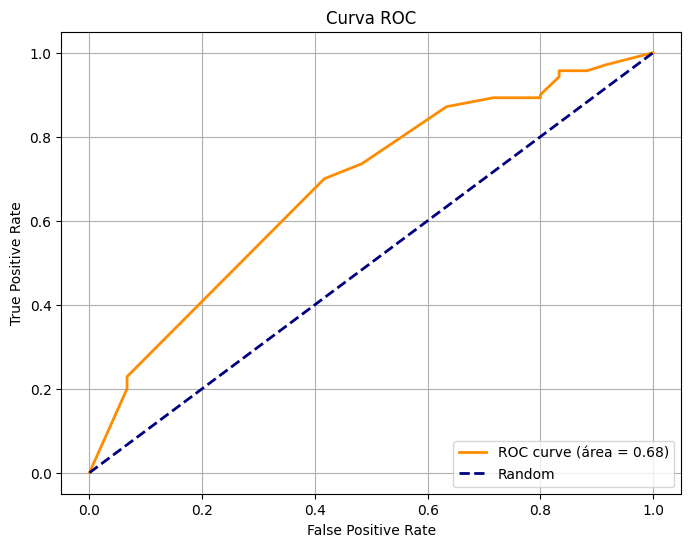

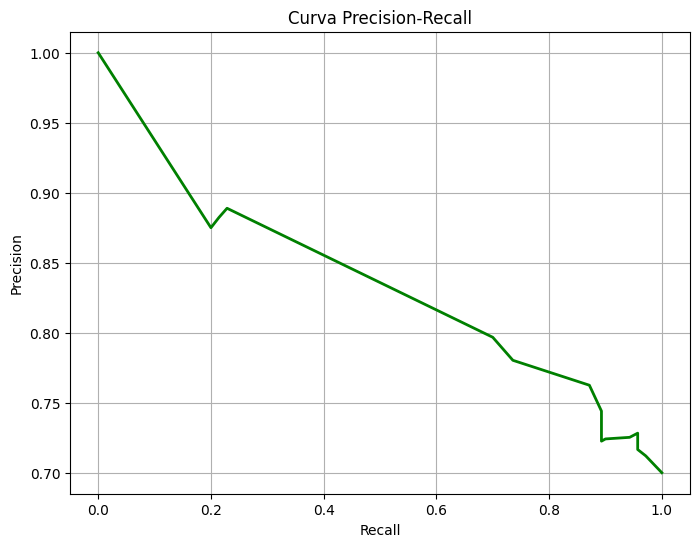

In [171]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# Melhor modelo treinado
best_model = random_search.best_estimator_

y_proba = best_model.predict_proba(X_test)[:, 1]

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

#### ROC e F1 score do caso base

In [172]:
from sklearn.metrics import f1_score, roc_auc_score

# Previsões
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidades para classe positiva


# Métricas
f1 = f1_score(y_test, y_pred, pos_label='good')  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test, y_proba)

print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

F1-score: 0.8065
ROC AUC: 0.6783


#### Matriz de confusão

In [173]:
y_pred_numeric = np.where(y_pred == 'good', 1, 0)


In [174]:
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_test_numeric, y_pred_numeric)  # y_test = valores reais, y_test_pred = predições
print(cm)

[[ 15  45]
 [ 15 125]]


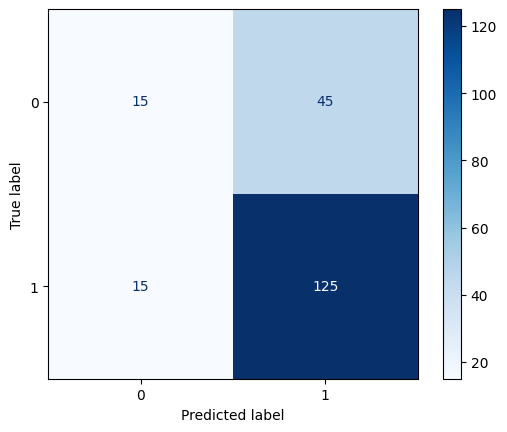

In [175]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# [[TN  FP]
#  [FN  TP]]

---
# Pre processamento



Agora que temos uma noção de como o modelo está indo sem o pre processamento, vamos faze-lo visando aumentar o recall e a precisão e avaliar com o caso anterior a area under curve (auc) do ROC do modelo anterior e saber se as alterações melhoraram ou não o caso mais simples. O modelo anterior servirá como métrica, se algum passo de pré processamento piorar o f1 score ou roc score retornamos o passo anterior e trocamos o processo.

#### estratificacao

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
X = pd.read_csv('class_german_credit.csv')
y = X['Risk']
X = X.drop('Risk', axis=1)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=0)

## Breve analise exploratória
---

In [178]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 355 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    int64 
 1   Sex               800 non-null    object
 2   Job               800 non-null    int64 
 3   Housing           800 non-null    object
 4   Saving accounts   657 non-null    object
 5   Checking account  486 non-null    object
 6   Credit amount     800 non-null    int64 
 7   Duration          800 non-null    int64 
 8   Purpose           800 non-null    object
dtypes: int64(4), object(5)
memory usage: 62.5+ KB


job é um atributo que está como inteiro mas é ordinal, teremos que usar ordinal encoder antes de tirar qualquer conclusão com ele. Colocarei job como ordinal nas etapas de seleção de variáveis e nos testes dentro dos pipelines.

In [179]:
X_train.describe()

,Age,Job,Credit amount,Duration
count,800.000000,800.000000,800.000000,800.000000
mean,35.438750,1.895000,3247.860000,20.916250
std,11.475991,0.645752,2775.170745,11.997465
min,19.000000,0.000000,276.000000,4.000000
25%,27.000000,2.000000,1363.250000,12.000000
50%,33.000000,2.000000,2281.500000,18.000000
75%,42.000000,2.000000,3965.250000,24.000000
max,75.000000,3.000000,15945.000000,72.000000


Podemos simplesmente ignorar o que describe diz sobre job, pois é um atributo ordinal que está sendo tratado como numérico

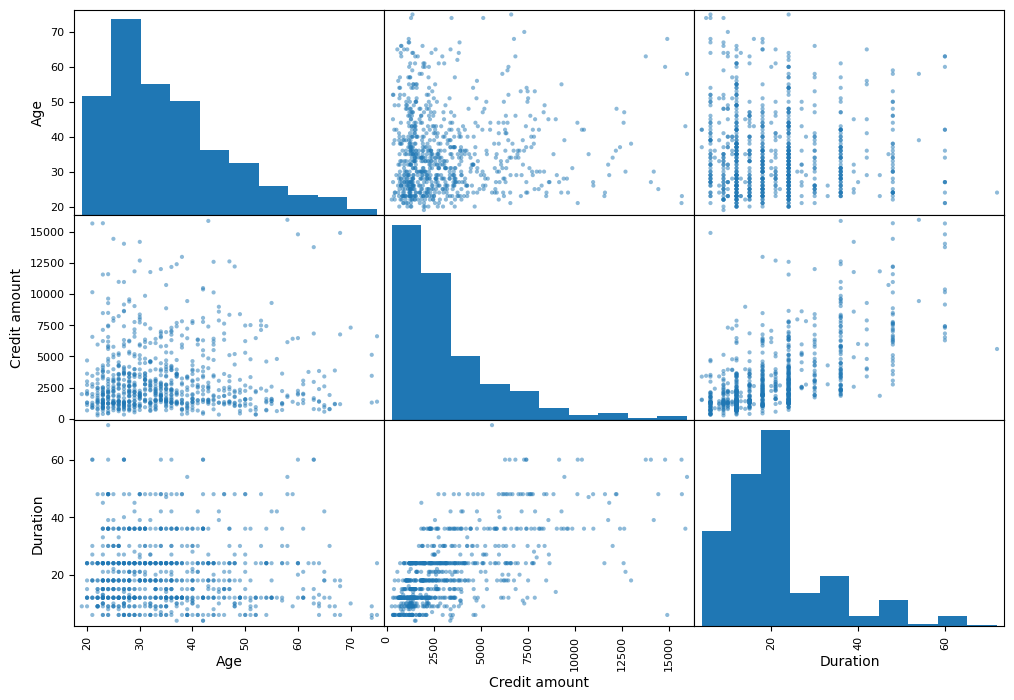

In [180]:
from pandas.plotting import scatter_matrix
atributes = ["Age", "Credit amount", "Duration"]
scatter_matrix(X_train[atributes], figsize=(12, 8))
plt.show()

In [181]:
numeric_columns = ['Age', 'Credit amount', 'Duration']
ordinal_columns = ['Saving accounts', 'Checking account']
nominal_columns = ['Sex', 'Housing', 'Purpose']
categories_order = [['little', 'moderate', 'quite rich', 'rich']]



Podemos perceber uma cauda alongada a direita em age, credit amount e Duration, tendo em vista isso, podemos além de normalizar os dados numericos, tambem aplicar uma transformação log.


Por mais que isso teoricamente seja eficaz, na prática isso se mostrou o contrário (Testes com log atrapalharam meu resultado). Portanto, a única transformação que manterei sera a normalização para não afetar KNN, Smote e outros métodos que valores discrepantes possam atrapalhar.


É possível perceber que nenhum dos dados segue a normal, todos estão longe da normalidade. Isso será provado com teste Shapiro e o teste Jarque-Bera


---
## Remoção de outliers

In [182]:
##Remover outliers com base no iqr
#Principais atributos com outliers: Age, Credit amount, Duration
import pandas as pd

def remove_outliers_iqr(df, columns):
    """
    Remove registros com outliers com base no IQR para as colunas especificadas.
    """
    df_clean = df.copy()

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.8 * IQR #1.8 pois temos muito pouco dados
        upper_bound = Q3 + 1.8 * IQR

        # Mantém apenas os registros dentro dos limites
        df_clean.loc[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound), col] = np.nan

    return df_clean

    # num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()


In [183]:
X_train_clean = X_train.copy()
train_clean = X_train_clean = remove_outliers_iqr(X_train, numeric_columns)


### Treino do baseline + remoção de outliers e normalização em dados numéricos.

In [184]:
job_categories = [0, 1, 2, 3]
ordinal_transformer = OrdinalEncoder(categories=[job_categories])
ord_preprocessor = Pipeline([
    ('encoder', ordinal_transformer)
])

from sklearn.preprocessing import FunctionTransformer, StandardScaler
scaler_transformer = StandardScaler()

num_preprocessor = Pipeline([
    ('scaler', scaler_transformer),
    ('imputer', KNNImputer(n_neighbors=5))
])

nom_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

param_dist = {
    'clf__max_depth': [None, 3, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy', 'log_loss']
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_clean, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer())]),
                                                                               ['Age',
                                                                                'Credit '
                                                                                'amount',
                                                                                'Duration']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OrdinalEncoder(categories=[['little',
                                                                                                                            'moderate',
                                                                                                                            'quite '
                                                                                                                            'rich',
                                                                                                                            'rich'],
                                                                                                                           ['little',
                                                                                                                            'moderate',
                                                                                                                            'rich']],
                                                                                                               handle_unknown='use_encoded_value...
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Sex',
                                                                                'Housing',
                                                                                'Purpose']),
                                                                              ('Job',
                                                                               'passthrough',
                                                                               ['Job'])])),
                                             ('clf',
                                              DecisionTreeClassifier(random_state=0))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__criterion': ['gini', 'entropy',
                                                           'log_loss'],
                                        'clf__max_depth': [None, 3, 5, 10, 20],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='roc_auc')

In [185]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  #Probabilidades para classe positiva

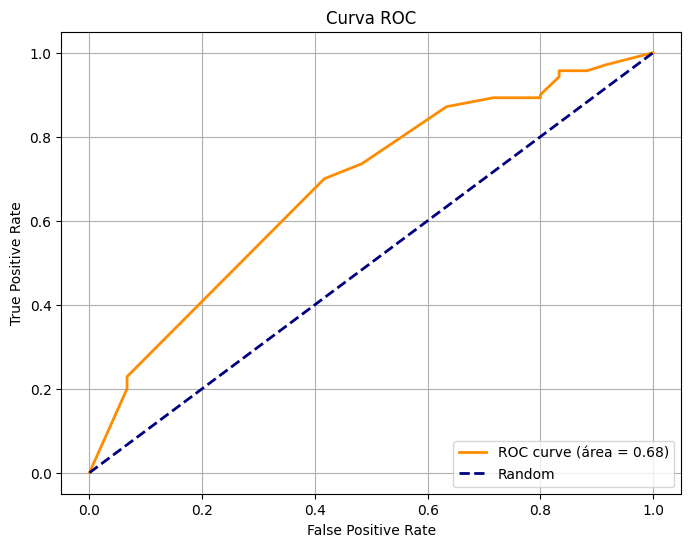

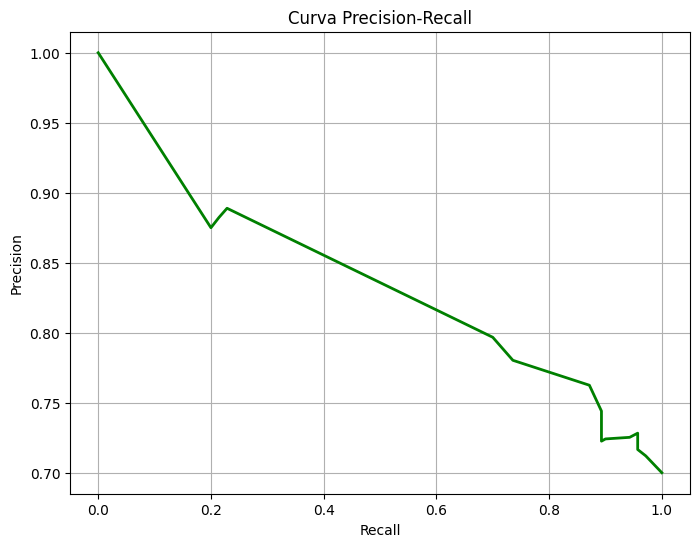

In [186]:
best_model = random_search.best_estimator_
y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

In [187]:
from sklearn.metrics import f1_score, roc_auc_score


# Métricas
f1 = f1_score(y_test, y_pred, pos_label='good')  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test, y_proba)

print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

F1-score: 0.8065
ROC AUC: 0.6783


Foi analisado o resultado retirando os outliers usando iqr com vários valores
1.5, 1.8... através de desvio padrão também, porém qualquer remoção de outlier demonstrou ter um efeito ruim em todos os casos, o que teve o melhor valor foi usando 1.8 como constante.

como foi feita:

Transformei os dados numéricos que são outliers em NaN's e usei um imputer para dados numéricos, porém como dito, teve um resultado pior.


---
## Agrupamento
A variável purpose tem os atributos domestic appliance e repairs com pouca ocorrência, portanto juntei a categoria domestic appliances em furniture/equipament, agrupei também repairs em vacation/other. O que semânticamente tem conexão.

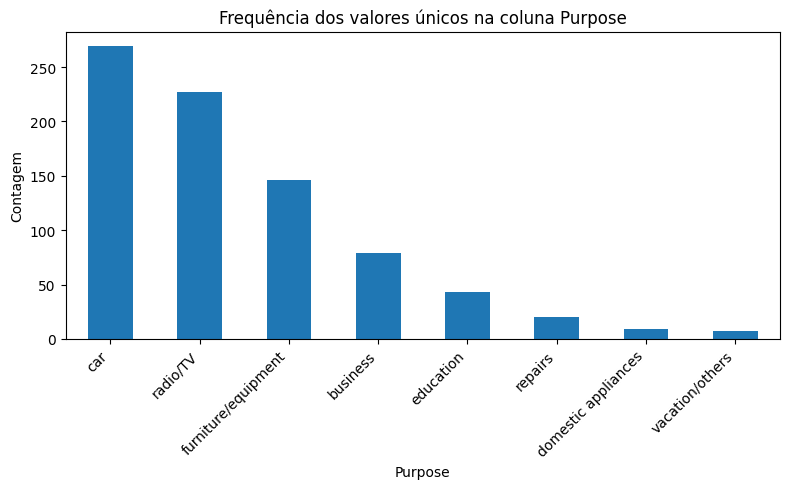

In [188]:
counts = X_train['Purpose'].value_counts()

# Plotar gráfico de barras
plt.figure(figsize=(8,5))
counts.plot(kind='bar')

plt.title('Frequência dos valores únicos na coluna Purpose')
plt.xlabel('Purpose')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')  # Deixa os nomes inclinados para facilitar leitura
plt.tight_layout()  # Ajusta layout para não cortar texto

plt.show()

In [189]:
def agrupar_purpose(valor):
    if valor == 'domestic appliances':
        return 'furniture/equipment'
    elif valor in ['repairs', 'vacation/others']:
        return 'vacation/others'
    else:
        return valor


In [190]:
X_train_grouped = X_train.copy()
X_train_grouped['Purpose'] = X_train['Purpose'].apply(agrupar_purpose)

In [191]:
X_train_grouped['Purpose'].unique()

array(['car', 'business', 'radio/TV', 'furniture/equipment', 'education',
       'vacation/others'], dtype=object)

In [192]:
X_test_grouped = X_test.copy()
X_test_grouped['Purpose'] = X_test['Purpose'].apply(agrupar_purpose)

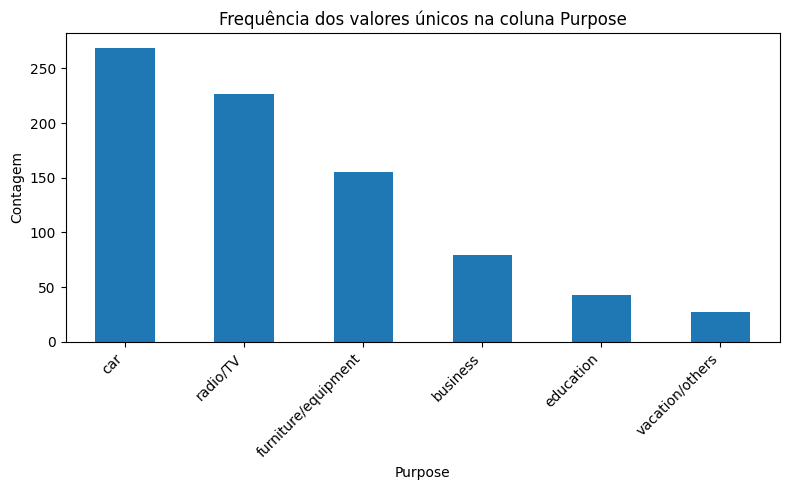

In [193]:
counts = X_train_grouped['Purpose'].value_counts()

# Plotar gráfico de barras
plt.figure(figsize=(8,5))
counts.plot(kind='bar')

plt.title('Frequência dos valores únicos na coluna Purpose')
plt.xlabel('Purpose')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')  # Deixa os nomes inclinados para facilitar leitura
plt.tight_layout()  # Ajusta layout para não cortar texto

plt.show()

In [194]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 355 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    int64 
 1   Sex               800 non-null    object
 2   Job               800 non-null    int64 
 3   Housing           800 non-null    object
 4   Saving accounts   657 non-null    object
 5   Checking account  486 non-null    object
 6   Credit amount     800 non-null    int64 
 7   Duration          800 non-null    int64 
 8   Purpose           800 non-null    object
dtypes: int64(4), object(5)
memory usage: 62.5+ KB


---

## Imputer's e um novo tratamento para as features checking account e saving accounts


### **Estratégia de Imputação de Dados**

Foram feitos teste exaustivos com imputer que mantivessem a semântica original dos atributos, ou seja imputar somente inteiros de 0 a 3 (['little', 'moderate', 'quite rich', 'rich']] = [0, 1, 2, 3]), como Knn imputer com arredondamento, Knn classifier, RandomForestClassifier, RandomForestRegressor com arredondamento, moda, etc. Os melhores resultados entre eles foi RandomForestRegressor com arredondamento e a própria moda. Porém ambos os resultados ficaram consideravelmente abaixo de usar RandomForestRegressor sem o arredondamento.

- **O que nos leva à questão:** "O que é melhor usar um imputador que mantenha a lógica proposta para os atributos e tenha um resultado pior, ou perder a semântica dessas 2 features imputando valores continuos, porém tendo um resultado melhor?"

- Como o resultado teve um ganho de cerca de 7% de ROC, preferi perder a semântica e tratar esses 2 atributos como valores numéricos e não ordinais.

- Você verá que tratarei Checking account e Saving accounts como simples numéricos e não ordinais, codifiquei os atributos inicialmente com ordinal encoder, porém usei smote NC e não coloquei como uma feature categórica ambos atributos, também imputarei valores continuos nessas variáveis.



### Random forest regressor com arredondamento como imputador - Mantém semântica dos atributos

In [195]:
numeric_columns = ['Age', 'Credit amount', 'Duration']
ordinal_columns = ['Saving accounts', 'Checking account']
nominal_columns = ['Sex', 'Housing', 'Purpose']
categories_order = [['little', 'moderate', 'quite rich', 'rich']]



In [196]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline([
  ('scaler', StandardScaler()),
])


In [197]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=15, random_state=42), # Exemplo
    max_iter=15,
    random_state=42,
    initial_strategy='most_frequent'
)

categories_saving_accounts = ['little', 'moderate', 'quite rich', 'rich']
categories_checking_account = ['little', 'moderate', 'rich']

list_of_category_orders = [categories_saving_accounts, categories_checking_account]

ordinal_encoder_for_imputation = OrdinalEncoder(
    categories=list_of_category_orders,
    handle_unknown='use_encoded_value', #Lida com valores desconhecidos no futuro
    unknown_value=np.nan #Mapeia desconhecidos para NaN, para que o imputer os trate
)


rounder = FunctionTransformer(lambda X: np.round(X), feature_names_out='one-to-one')

ordinal_pipeline = Pipeline([
    ('encoder', ordinal_encoder_for_imputation),
    ('imputer', iter_imputer),
    ('rounder', rounder)
])


In [198]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder


ohe = OneHotEncoder(handle_unknown='ignore')
# ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# target = TargetEncoder()

nominal_pipeline = Pipeline([
    ('encoder', ohe)
])



In [199]:
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('ord', ordinal_pipeline, ordinal_columns),
    ('nom', nominal_pipeline, nominal_columns),
    ('Job', 'passthrough', ['Job'])
])

In [200]:
param_dist = {
    'clf__max_depth': [None, 3, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4,],
    'clf__criterion': ['gini', 'entropy'],

    # Hiperparâmetros do IterativeImputer
    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],
}


pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=0))
])


random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=0
)

random_search.fit(X_train_grouped, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Credit '
                                                                                'amount',
                                                                                'Duration']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OrdinalEncoder(categories=[['little',
                                                                                                                            'moderate',
                                                                                                                            'quite '
                                                                                                                            'rich',
                                                                                                                            'rich'],
                                                                                                                           ['little',
                                                                                                                            'moderate',
                                                                                                                            'rich']],
                                                                                                               handle_unknown='use_encoded_va...
                                              DecisionTreeClassifier(random_state=0))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__criterion': ['gini', 'entropy'],
                                        'clf__max_depth': [None, 3, 5, 10, 20],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10],
                                        'preprocess__ord__imputer__estimator__n_estimators': [5,
                                                                                              10,
                                                                                              20],
                                        'preprocess__ord__imputer__max_iter': [5,
                                                                               10,
                                                                               15]},
                   random_state=0, scoring='roc_auc')

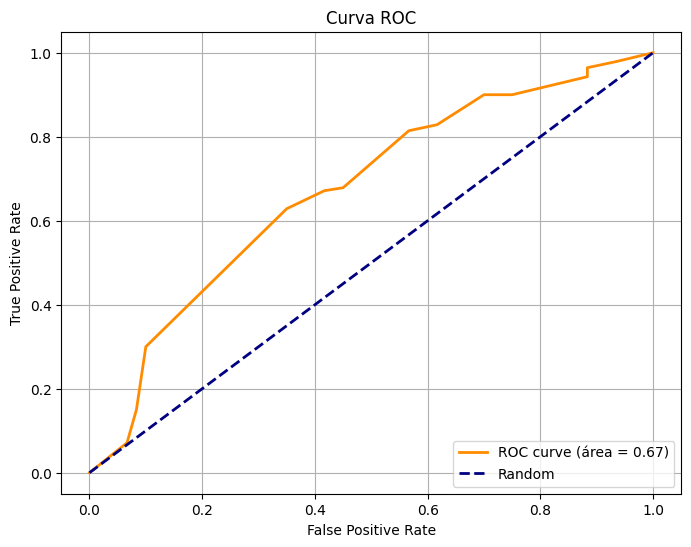

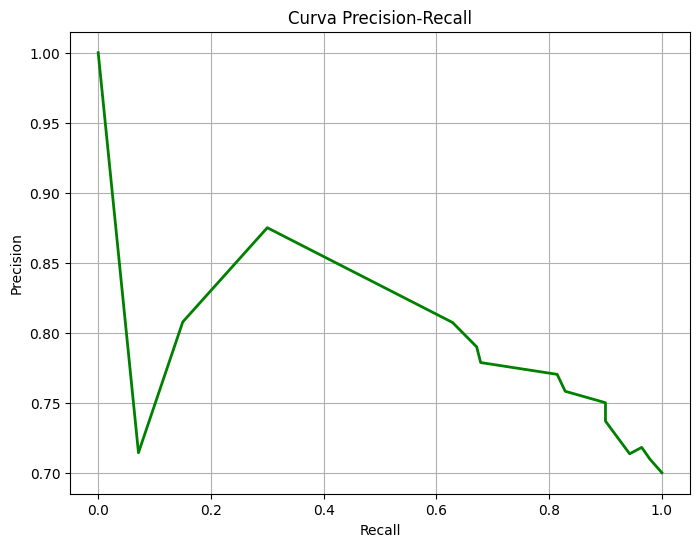

In [201]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

best_model = random_search.best_estimator_
y_proba = best_model.predict_proba(X_test_grouped)[:, 1]

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Also convert y_test for the precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

In [202]:
from sklearn.metrics import f1_score, roc_auc_score

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidades para classe positiva

f1 = f1_score(y_test, y_pred, pos_label='good')  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test, y_proba)

print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")


F1-score: 0.8103
ROC AUC: 0.6724



### Random forest regressor sem arredondamento como imputador - Perda da semântica dos atributos


- agrupamento do atributo Purpose.
- Remocao dos Nan's dos atributos Saving accounts e Checking account com random forest regressor sem arredondamento
- normalização de dados numéricos
- Sem remoção de outliers

A intenção de não usar arredondamento ou não usar o randomForestClassifier para imputação é de permitir que modelos baseados em árvores fação sua própria descritização do dado. Teoricamente isso não seria uma adequado, porém os testes demonstraram o contrário.

In [203]:
numeric_columns = ['Age', 'Credit amount', 'Duration']
ordinal_columns = ['Saving accounts', 'Checking account']
nominal_columns = ['Sex', 'Housing', 'Purpose']
categories_order = [['little', 'moderate', 'quite rich', 'rich']]

In [204]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline([
  ('scaler', StandardScaler()),
])

In [205]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier


categories_saving_accounts = ['little', 'moderate', 'quite rich', 'rich']
categories_checking_account = ['little', 'moderate', 'rich']
list_of_category_orders = [categories_saving_accounts, categories_checking_account]

ordinal_encoder_for_imputation = OrdinalEncoder(
    categories=list_of_category_orders,
    handle_unknown='use_encoded_value', #Lida com valores desconhecidos no futuro
    unknown_value=np.nan #Mapeia desconhecidos para NaN, para que o imputer os trate
)

iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=15, random_state=42), # Exemplo
    max_iter=15,
    random_state=42,
    initial_strategy='most_frequent'
)


ordinal_pipeline = Pipeline([
    ('encoder', ordinal_encoder_for_imputation),
    ('imputer', iter_imputer)
])

ohe = OneHotEncoder(handle_unknown='ignore')

nominal_pipeline = Pipeline([
    ('encoder', ohe)
])



In [206]:
preprocessor1 = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('ord', ordinal_pipeline, ordinal_columns),
    ('nom', nominal_pipeline, nominal_columns),
    ('Job', 'passthrough', ['Job'])
])

In [207]:
param_dist = {
    'clf__max_depth': [None, 3, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4,],
    'clf__criterion': ['gini', 'entropy'],

}


pipeline1 = Pipeline([
    ('preprocess', preprocessor1),
    ('clf', DecisionTreeClassifier(random_state=0))
])


random_search = RandomizedSearchCV(
    pipeline1,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=0
)

random_search.fit(X_train_grouped, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Credit '
                                                                                'amount',
                                                                                'Duration']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OrdinalEncoder(categories=[['little',
                                                                                                                            'moderate',
                                                                                                                            'quite '
                                                                                                                            'rich',
                                                                                                                            'rich'],
                                                                                                                           ['little',
                                                                                                                            'moderate',
                                                                                                                            'rich']],
                                                                                                               handle_unknown='use_encoded_va...
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Sex',
                                                                                'Housing',
                                                                                'Purpose']),
                                                                              ('Job',
                                                                               'passthrough',
                                                                               ['Job'])])),
                                             ('clf',
                                              DecisionTreeClassifier(random_state=0))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__criterion': ['gini', 'entropy'],
                                        'clf__max_depth': [None, 3, 5, 10, 20],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10]},
                   random_state=0, scoring='roc_auc')

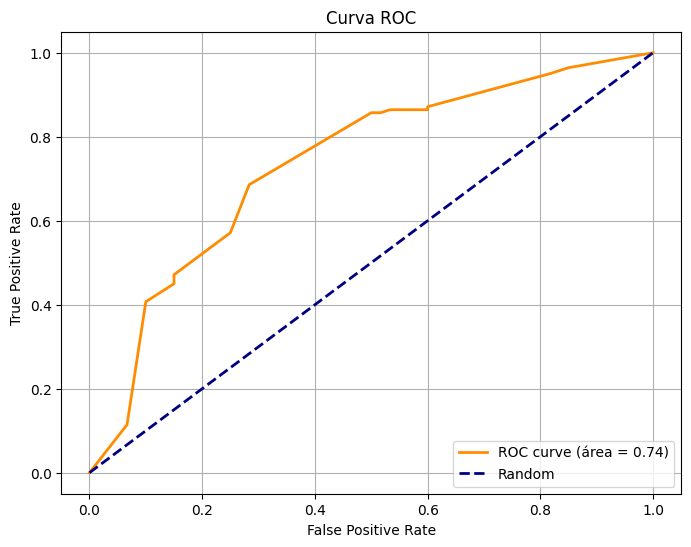

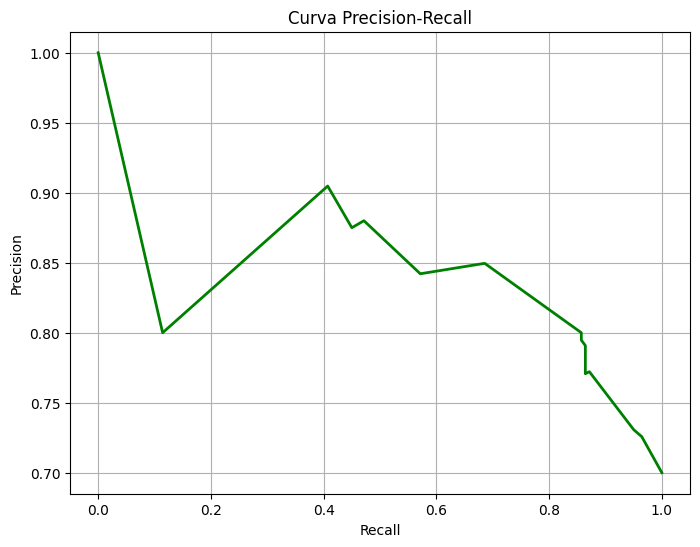

In [208]:
best_model = random_search.best_estimator_
y_proba = best_model.predict_proba(X_test_grouped)[:, 1]

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

In [209]:
from sklearn.metrics import f1_score, roc_auc_score

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidades para classe positiva

f1 = f1_score(y_test, y_pred, pos_label='good')  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test, y_proba)

print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")


F1-score: 0.8148
ROC AUC: 0.7370


**Conclusão:** Veja que random Forest regressor sem arredondamento como imputador teve um resultado de **ROC de 73,7%**, enquanto moda e random forest regressor com arredondamento como imputador teve ambos **68% e 67% de Roc.**

#### Data set sem missing values

Vou precisar do dataset sem missing values para usar smote + tomek link

In [210]:
preprocessor1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age', 'Credit amount', 'Duration']),
                                ('ord',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(categories=[['little',
                                                                              'moderate',
                                                                              'quite '
                                                                              'rich',
                                                                              'rich'],
                                                                             ['little',
                                                                              'moderate',
                                                                              'rich']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('imputer',
                                                  IterativeImputer(estimator=RandomForestRegressor(n_estimators=15,
                                                                                                   random_state=42),
                                                                   initial_strategy='most_frequent',
                                                                   max_iter=15,
                                                                   random_state=42))]),
                                 ['Saving accounts', 'Checking account']),
                                ('nom',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Housing', 'Purpose']),
                                ('Job', 'passthrough', ['Job'])])

In [211]:
X_transformed = preprocessor1.fit_transform(X_train_grouped)

In [212]:
from sklearn.compose import make_column_selector as selector

ordinal_names = ordinal_columns
nominal_feature_names = preprocessor1.named_transformers_['nom']['encoder'].get_feature_names_out(nominal_columns)
numeric_names = numeric_columns
remainder_names = ['Job']

all_feature_names = np.concatenate([numeric_names, ordinal_names, nominal_feature_names, remainder_names])

X_train_transformed = pd.DataFrame(X_transformed, columns=all_feature_names, index=X_train_clean.index)
X_train_transformed.head()


,Age,Credit amount,Duration,Saving accounts,Checking account,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_vacation/others,Job
355,-1.084571,-0.721798,0.257194,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
661,-1.084571,-0.846553,-0.743643,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
300,1.618410,-0.928761,-1.244061,0.000000,0.530784,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
916,-0.299835,-0.144175,-0.910449,1.000000,0.856188,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
294,0.920867,1.579680,2.258868,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [213]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 355 to 439
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          800 non-null    float64
 1   Credit amount                800 non-null    float64
 2   Duration                     800 non-null    float64
 3   Saving accounts              800 non-null    float64
 4   Checking account             800 non-null    float64
 5   Sex_female                   800 non-null    float64
 6   Sex_male                     800 non-null    float64
 7   Housing_free                 800 non-null    float64
 8   Housing_own                  800 non-null    float64
 9   Housing_rent                 800 non-null    float64
 10  Purpose_business             800 non-null    float64
 11  Purpose_car                  800 non-null    float64
 12  Purpose_education            800 non-null    float64
 13  Purpose_furniture/equip

---
## Balanceamento do treinamento

In [214]:
##Verificar balanceamento do dataset de treino
def percentual_categorias_onehot(df_onehot):
    """
    Recebe um DataFrame já transformado com OneHotEncoder.
    Retorna o percentual de cada categoria (coluna) com base na soma dos 1s.
    """
    total = len(df_onehot)
    print(df_onehot.sum(axis=0))

    percentuais = (df_onehot.sum(axis=0) / total) * 100
    return percentuais.sort_values(ascending=False).round(2)


In [215]:
percentual_categorias_onehot(pd.get_dummies(y_train))

bad     240
good    560
dtype: int64


,0
good,70.0
bad,30.0


Os dados estão em um proporção de 70 - 30, sabendo disso podemos usar smote e tomek link

### Para o balancemento usarei Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE NC) com tomek link.

In [216]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN

smotenc = SMOTENC(
        # categorical_features=[3, 4, 5, 6, 7, 8],
        categorical_features=[5,6,7,8,9,10,11,12,13,14,15, 16],
        sampling_strategy=0.6667,
        random_state=42
    )

resampler = SMOTETomek(
    smote= smotenc,
    random_state=42
)

# resampler = SMOTEENN(
#     smote=smotenc,
#     random_state=42
# )
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_transformed, y_train)


In [217]:
X_train_resampled = pd.DataFrame(X_train_resampled, columns=all_feature_names)

In [218]:
y_train_resampled = pd.Series(y_train_resampled)

In [219]:
X_train_resampled.head()

,Age,Credit amount,Duration,Saving accounts,Checking account,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_vacation/others,Job
0,-1.084571,-0.721798,0.257194,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-1.084571,-0.846553,-0.743643,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
2,1.618410,-0.928761,-1.244061,0.000000,0.530784,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.299835,-0.144175,-0.910449,1.000000,0.856188,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
4,0.920867,1.579680,2.258868,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [220]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          833 non-null    float64
 1   Credit amount                833 non-null    float64
 2   Duration                     833 non-null    float64
 3   Saving accounts              833 non-null    float64
 4   Checking account             833 non-null    float64
 5   Sex_female                   833 non-null    float64
 6   Sex_male                     833 non-null    float64
 7   Housing_free                 833 non-null    float64
 8   Housing_own                  833 non-null    float64
 9   Housing_rent                 833 non-null    float64
 10  Purpose_business             833 non-null    float64
 11  Purpose_car                  833 non-null    float64
 12  Purpose_education            833 non-null    float64
 13  Purpose_furniture/eq

In [221]:
percentual_categorias_onehot(pd.get_dummies(y_train_resampled))

bad     323
good    510
dtype: int64


,0
good,61.22
bad,38.78


---
## Teste 2 - usando SMOTE para imputacao de dados
observe que escolhi balancear 60 - 40 ao inves de 50-50.

- SMOTE NC
- agrupamento de purpose
- Remocao dos Nan's dos atributos Saving accounts e Checking account
- Sem remoção de outlier
- normalização de dados numéricos

In [222]:
X_train_grouped.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
355,23,male,1,own,little,moderate,1246,24,car
661,23,male,2,own,NaN,little,900,12,car
300,54,female,0,own,little,NaN,672,6,car
916,32,male,2,own,moderate,NaN,2848,10,car
294,46,male,3,own,NaN,NaN,7629,48,business


In [223]:
X_train_transformed.head()

,Age,Credit amount,Duration,Saving accounts,Checking account,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_vacation/others,Job
355,-1.084571,-0.721798,0.257194,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
661,-1.084571,-0.846553,-0.743643,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
300,1.618410,-0.928761,-1.244061,0.000000,0.530784,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
916,-0.299835,-0.144175,-0.910449,1.000000,0.856188,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
294,0.920867,1.579680,2.258868,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [224]:
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline2 = ImbPipeline([
    ('preprocess', preprocessor1),
    ('resample', SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14,15,16],
            sampling_strategy=0.6667,
            random_state=42
        )
    ),

  ('clf', DecisionTreeClassifier(random_state=0))
])


In [225]:
X_transformed.shape

(800, 17)

In [226]:


from imblearn.pipeline import Pipeline


param_dist = {
    'clf__max_depth': [None, 3, 5, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy'],

    # IterativeImputer: se quiser otimizar junto
    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],

    # SMOTENC: número de vizinhos no oversampling
    'resample__k_neighbors': [3, 5, 7]
}

search = RandomizedSearchCV(
    pipeline2,
    param_distributions=param_dist,
    n_iter=100,
    scoring={
        'roc_auc': 'roc_auc',
        # 'f1': make_scorer(f1_score)
    },
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_grouped, y_train)

print(search.best_params_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'resample__k_neighbors': 3, 'preprocess__ord__imputer__max_iter': 5, 'preprocess__ord__imputer__estimator__n_estimators': 5, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': 3, 'clf__criterion': 'gini'}


In [227]:
search.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Credit amount',
                                                   'Duration']),
                                                 ('ord',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(categories=[['little',
                                                                                               'moderate',
                                                                                               'quite '
                                                                                               'rich',
                                                                                               'rich'],
                                                                                              ['little',
                                                                                               'moderate',
                                                                                               'rich']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Housing',
                                                   'Purpose']),
                                                 ('Job', 'passthrough',
                                                  ['Job'])])),
                ('resample',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9, 10, 11, 12, 13,
                                               14, 15, 16],
                         k_neighbors=3, random_state=42,
                         sampling_strategy=0.6667)),
                ('clf',
                 DecisionTreeClassifier(max_depth=3, min_samples_leaf=2,
                                        min_samples_split=5, random_state=0))])

In [228]:
from sklearn.metrics import f1_score, roc_auc_score
X_test_group = X_test.copy()
X_test_group['Purpose'] = X_test_group['Purpose'].apply(agrupar_purpose)
best_model = search.best_estimator_
y_pred = best_model.predict(X_test_group)
y_proba = best_model.predict_proba(X_test_group)[:, 1]


f1 = f1_score(y_test, y_pred, pos_label='good')  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test, y_proba)

print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")


F1-score: 0.7972
ROC AUC: 0.7247


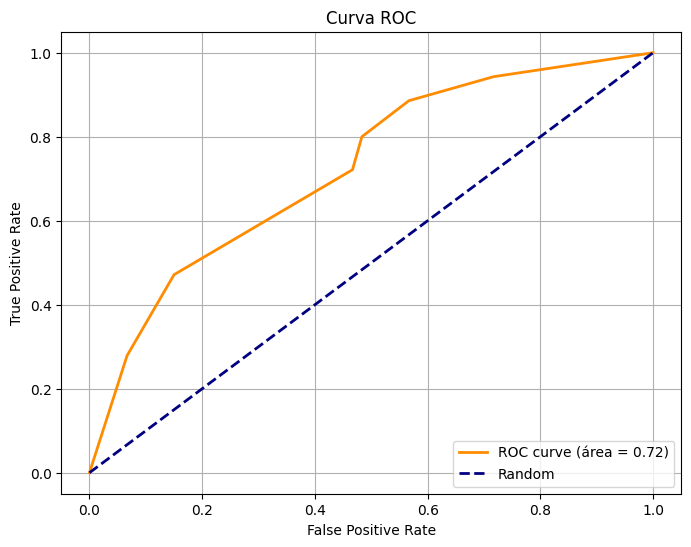

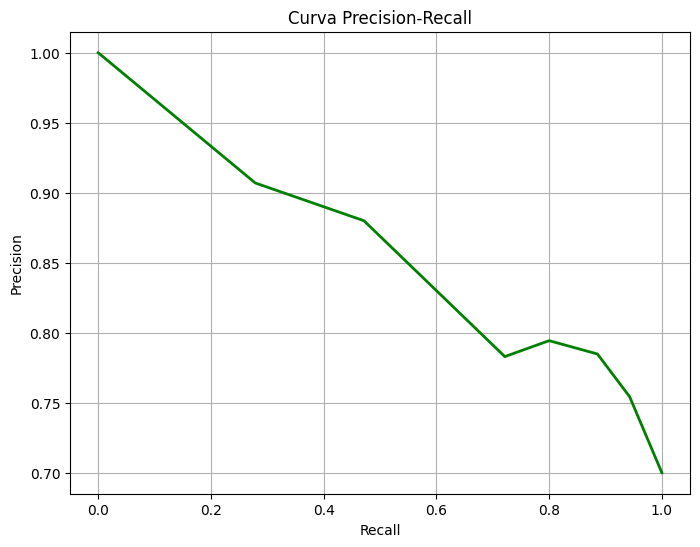

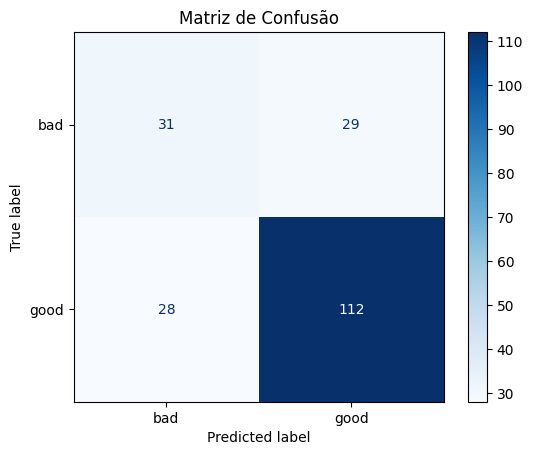

In [229]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obter o melhor modelo
best_model = search.best_estimator_

# Prever probabilidades e classes
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Converter y_test para numérico
y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

# 1. Curva ROC
fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 2. Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

# Converter y_pred para os mesmos valores numéricos que y_test_numeric
y_pred_numeric = np.where(y_pred == 'good', 1, 0)

# Usar y_pred_numeric em vez de y_pred nas métricas
cm = confusion_matrix(y_test_numeric, y_pred_numeric)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bad', 'good'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão')
plt.show()
# # Opcional: Imprimir métricas adicionais
# from sklearn.metrics import classification_report
# print("\nRelatório de Classificação:")
# print(classification_report(y_test_numeric, y_pred, target_names=['bad', 'good']))

### Sobre o resultado

Em meus experimentos, notei:

Apesar do treinamento sem usar Smote + tomeklink aparentar em imediato ter um resultado melhor, quando aplico **seleção de variáveis** usando a base **já balanceada** (e removo o pior atributo identificado), o desempenho melhora consideravelmente: sai de 73.7% de ROC para mais de 75% de ROC.

- Tentar **remover o mesmo atributo** na base desbalanceada não teve o mesmo efeito positivo.
- Tentar aplicar a seleção de variáveis na base desbalanceada e tirar os atributos que eram piores também não gerou ganhos significativos.


#### ⚠️ Sobre a demonstração prática no notebook

Este efeito não está demonstrado **neste notebook específico** por uma questão de clareza e organização:  
- Para evidenciar a diferença, seria necessário **ramificar todo o pipeline em duas abordagens paralelas**, com e sem balanceamento, duplicando blocos de código e gráficos.  
- Isso tornaria o notebook excessivamente longo e mais difícil de ler.  
- Como objetivo aqui é apresentar um fluxo limpo, optei por não incluir esse ramo.



---
# Seleção de variáveis

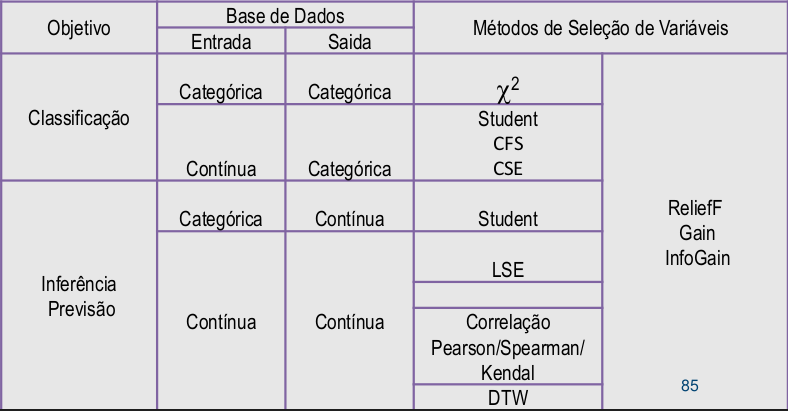

In [230]:
## RESUMO DE ALGORITMOS PARA SELEÇÃO DE VARIÁVEIS
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('resumo.png')
cv2_imshow(img)

##Dataset de treino final e dataset para seleção de feature
Separei em 2 datasets diferentes o que será utilizado para treino de fato com onehotencode, smote, ordinalencode... e outro para selecao de feature que não podemos ter os atributos com onehotencode.

In [231]:
smote_tomek_transformer = SMOTETomek(
    smote=SMOTENC(
        categorical_features=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
        sampling_strategy=0.6667, # Ou a estratégia desejada
        random_state=42
    ),
    random_state=42
)

transformation_pipeline = ImbPipeline([
    ('preprocess', preprocessor1),          # Seu ColumnTransformer
    ('resample', smote_tomek_transformer)  # Seu SMOTETomek configurado
])

# X_train_transformed, y_train_transformed = transformation_pipeline.fit_resample(X_train_grouped, y_train)

In [232]:
from imblearn.pipeline import Pipeline as ImbPipeline

# Pipeline já criado
X_train_transformed, y_train_transformed = transformation_pipeline.fit_resample(X_train_grouped, y_train)

# Converter X_train_transformed para DataFrame
feature_names = transformation_pipeline.named_steps['preprocess'].get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)


In [233]:
X_train_transformed_df.head()  # com OneHotEncoder aplicado


,num__Age,num__Credit amount,num__Duration,ord__Saving accounts,ord__Checking account,nom__Sex_female,nom__Sex_male,nom__Housing_free,nom__Housing_own,nom__Housing_rent,nom__Purpose_business,nom__Purpose_car,nom__Purpose_education,nom__Purpose_furniture/equipment,nom__Purpose_radio/TV,nom__Purpose_vacation/others,Job__Job
0,-1.084571,-0.721798,0.257194,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-1.084571,-0.846553,-0.743643,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
2,1.618410,-0.928761,-1.244061,0.000000,0.530784,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.299835,-0.144175,-0.910449,1.000000,0.856188,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
4,0.920867,1.579680,2.258868,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [234]:
X_train_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   num__Age                          833 non-null    float64
 1   num__Credit amount                833 non-null    float64
 2   num__Duration                     833 non-null    float64
 3   ord__Saving accounts              833 non-null    float64
 4   ord__Checking account             833 non-null    float64
 5   nom__Sex_female                   833 non-null    float64
 6   nom__Sex_male                     833 non-null    float64
 7   nom__Housing_free                 833 non-null    float64
 8   nom__Housing_own                  833 non-null    float64
 9   nom__Housing_rent                 833 non-null    float64
 10  nom__Purpose_business             833 non-null    float64
 11  nom__Purpose_car                  833 non-null    float64
 12  nom__Pur

In [235]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

X_train_transformed, y_train_transformed = transformation_pipeline.fit_resample(X_train_grouped, y_train)

feature_names = transformation_pipeline.named_steps['preprocess'].get_feature_names_out()
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names, index=y_train_transformed.index)

ohe_encoder = transformation_pipeline.named_steps['preprocess'].named_transformers_['nom'].named_steps['encoder']

ohe_cols = [col for col in feature_names if col.startswith('nom__')]

X_ohe_part = X_train_transformed[ohe_cols].copy()

X_ohe_inversed = ohe_encoder.inverse_transform(X_ohe_part.values)

X_ohe_inversed_df = pd.DataFrame(X_ohe_inversed, columns=nominal_columns, index=X_train_transformed.index)

X_train_without_ohe = X_train_transformed.drop(columns=ohe_cols)

X_train_without_ohe = pd.concat([X_train_without_ohe, X_ohe_inversed_df], axis=1)

print("DataFrame com OHE:", X_train_transformed.shape)
print("DataFrame com OHE invertido:", X_train_without_ohe.shape)


DataFrame com OHE: (833, 17)
DataFrame com OHE invertido: (833, 9)


In [236]:
X_train_transformed.head()

,num__Age,num__Credit amount,num__Duration,ord__Saving accounts,ord__Checking account,nom__Sex_female,nom__Sex_male,nom__Housing_free,nom__Housing_own,nom__Housing_rent,nom__Purpose_business,nom__Purpose_car,nom__Purpose_education,nom__Purpose_furniture/equipment,nom__Purpose_radio/TV,nom__Purpose_vacation/others,Job__Job
0,-1.084571,-0.721798,0.257194,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-1.084571,-0.846553,-0.743643,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
2,1.618410,-0.928761,-1.244061,0.000000,0.530784,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.299835,-0.144175,-0.910449,1.000000,0.856188,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
4,0.920867,1.579680,2.258868,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [237]:
def remover_prefixos_colunas(df, prefixos):
    """
    Remove os prefixos dados de cada nome de coluna de um DataFrame.

    Exemplo: 'num__Age' → 'Age'
    """
    novo_nome_colunas = [
        col.split("__", 1)[1] if any(col.startswith(prefix + "__") for prefix in prefixos) else col
        for col in df.columns
    ]
    df.columns = novo_nome_colunas
    return df


In [238]:
# Lista de prefixos usados no seu ColumnTransformer
prefixos_usados = ['num', 'ord', 'Job']

# Aplica a renomeação
X_train_without_ohe = remover_prefixos_colunas(X_train_without_ohe, prefixos_usados)
prefixos_usados = ['num', 'ord', 'nom', 'Job']

X_train_transformed = remover_prefixos_colunas(X_train_transformed, prefixos_usados)

In [239]:
X_train_transformed.head()

,Age,Credit amount,Duration,Saving accounts,Checking account,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_vacation/others,Job
0,-1.084571,-0.721798,0.257194,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-1.084571,-0.846553,-0.743643,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
2,1.618410,-0.928761,-1.244061,0.000000,0.530784,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.299835,-0.144175,-0.910449,1.000000,0.856188,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
4,0.920867,1.579680,2.258868,0.216481,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [240]:
X_train_without_ohe.head()

,Age,Credit amount,Duration,Saving accounts,Checking account,Job,Sex,Housing,Purpose
0,-1.084571,-0.721798,0.257194,0.000000,1.000000,1.0,male,own,car
1,-1.084571,-0.846553,-0.743643,0.216481,0.000000,2.0,male,own,car
2,1.618410,-0.928761,-1.244061,0.000000,0.530784,0.0,female,own,car
3,-0.299835,-0.144175,-0.910449,1.000000,0.856188,2.0,male,own,car
4,0.920867,1.579680,2.258868,0.216481,0.000000,3.0,male,own,business


In [241]:
# Remove colunas OHE do DataFrame original
X_train_with_ohe = X_train_transformed_df.drop(columns=ohe_cols)

# Junta as colunas nominais decodificadas
X_train_with_ohe = pd.concat([X_train_with_ohe, X_ohe_inversed_df], axis=1)


---
---
## Avaliação de normalidade
---
---

In [242]:
numeric_columns = ['Age', 'Credit amount', 'Duration']


In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

def histograma_colunas(df, colunas):

  for coluna in colunas:
    plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10, 6))
    sns.histplot(df[coluna], kde=True)
    plt.title(f'Histograma da Coluna {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Frequência')
    plt.show()


<Figure size 1000x600 with 0 Axes>

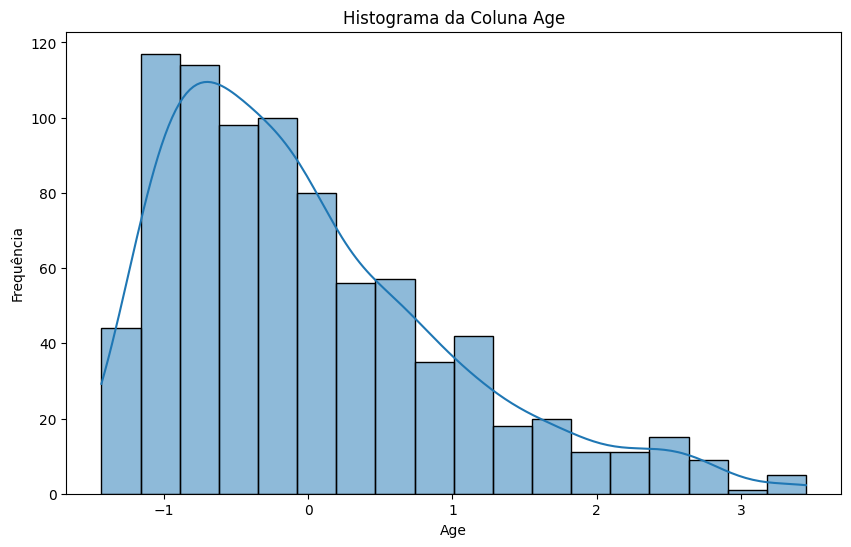

<Figure size 1000x600 with 0 Axes>

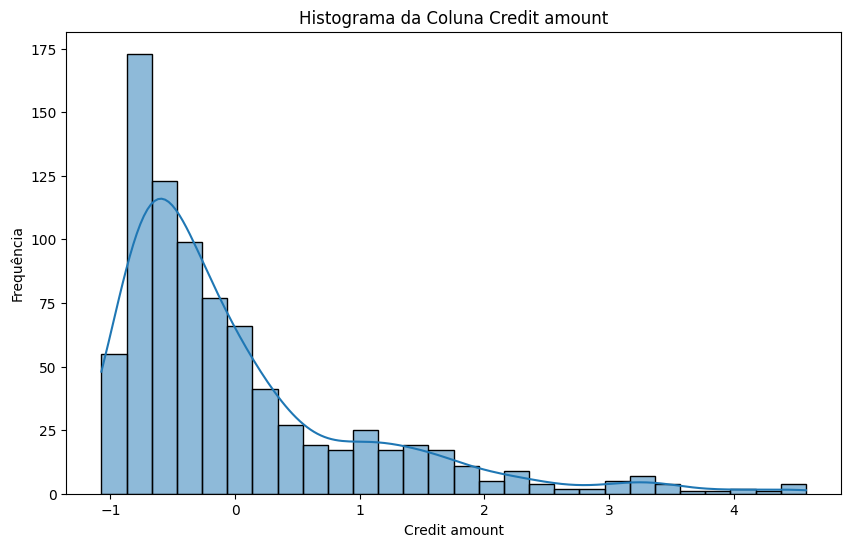

<Figure size 1000x600 with 0 Axes>

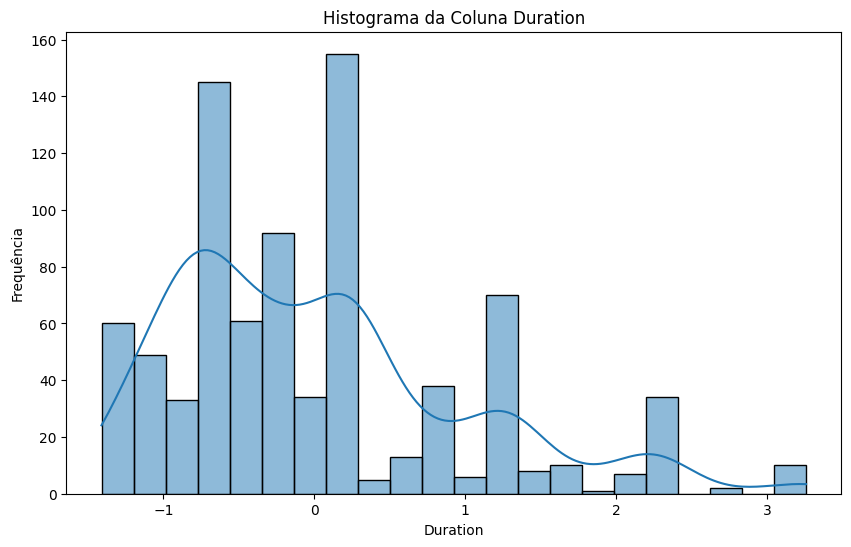

In [244]:
histograma_colunas(X_train_without_ohe, numeric_columns)

In [245]:
import pandas as pd
from scipy import stats
import numpy as np

def testar_normalidade_colunas_especificas(df: pd.DataFrame, colunas_para_testar: list, alpha: float = 0.05):

    lista_resultados = []

    for coluna in colunas_para_testar:

        dados = df[coluna].dropna()

        stat_sw, p_valor_sw = stats.shapiro(dados)
        decisao_sw = 'Normal' if p_valor_sw > alpha else 'Não Normal'

        stat_jb, p_valor_jb = stats.jarque_bera(dados)
        decisao_jb = 'Normal' if p_valor_jb > alpha else 'Não Normal'

        lista_resultados.append({
            'Variável': coluna,
            'P-Valor (Shapiro)': f"{p_valor_sw:.4f}",
            'Decisão (Shapiro)': decisao_sw,
            'P-Valor (Jarque-Bera)': f"{p_valor_jb:.4f}",
            'Decisão (Jarque-Bera)': decisao_jb
        })

    df_resultados = pd.DataFrame(lista_resultados)
    return df_resultados



In [246]:
is_normal = testar_normalidade_colunas_especificas(X_train_without_ohe, colunas_para_testar=numeric_columns)

In [247]:
is_normal

,Variável,P-Valor (Shapiro),Decisão (Shapiro),P-Valor (Jarque-Bera),Decisão (Jarque-Bera)
0,Age,0.0000,Não Normal,0.0000,Não Normal
1,Credit amount,0.0000,Não Normal,0.0000,Não Normal
2,Duration,0.0000,Não Normal,0.0000,Não Normal


###Dados longe da normalidade.
Nos impede de usar Pearson e de usar o teste t de Student.

###Para fazer a seleção de variáveis, não podemos ter colunas onehotencoded. Logo iremos criar uma cópia para trabalhar na seleção de variáveis

In [248]:
X_train_variable_selection_ohe = X_train_transformed.copy()
X_train_variable_selection = X_train_without_ohe.copy()


### Algoritmos que serão usados
Como não temos normalidade não podemos usar nem Pearson nem teste t de Student, portanto usarei os seguintes algoritmos para avaliar as features:


- para categorica - categoria -> chi 2
- para continua - continua -> kendal (tal b)
- reliefF -> tabela toda
- mutual information -> tabela toda

## teste de χ² (relação categorica-categorica)


In [249]:
##Relatorio teste chi quadrado - baseado no codigo implementado no slide
import pandas as pd
from scipy.stats import chi2_contingency, chi2
from collections import Counter

def perform_chi2_test(input_series, output_series, alpha=0.05, feature_name="Variável de Entrada"):

    input_series = input_series.reset_index(drop=True)
    output_series = output_series.reset_index(drop=True)

    contingency_table = pd.crosstab(input_series, output_series)

    stat, p, dof, expected = chi2_contingency(contingency_table)

    print(f"\nGraus de Liberdade (dof): {dof}")

    prob = 1 - alpha
    critical_value = chi2.ppf(prob, dof)

    print(f"\nNível de significância (alpha): {alpha}")
    print(f"Valor crítico Qui-Quadrado: {critical_value:.4f}")
    print(f"Estatística Qui-Quadrado calculada (stat): {stat:.4f}")
    print("\nInterpretação baseada na Estatística do Teste vs. Valor Crítico:")

    if abs(stat) >= critical_value:
        print(f"Resultado: Dependentes (rejeitar H0). A estatística ({stat:.4f}) é >= valor crítico ({critical_value:.4f}).")
        print(f"Há uma associação estatisticamente significativa entre '{feature_name}' e a variável de saída.")
    else:
        print(f"Resultado: Independentes (falha em rejeitar H0). A estatística ({stat:.4f}) é < valor crítico ({critical_value:.4f}).")
        print(f"Não há evidência suficiente para dizer que '{feature_name}' e a variável de saída são dependentes.")

    print("\nInterpretação baseada no Valor-p:")
    print(f"Valor-p: {p:.4f}")
    if p <= alpha:
        print(f"Resultado: Dependentes (rejeitar H0). O valor-p ({p:.4f}) é <= alpha ({alpha}).")
        print(f"Há uma associação estatisticamente significativa entre '{feature_name}' e a variável de saída.")
    else:
        print(f"Resultado: Independentes (falha em rejeitar H0). O valor-p ({p:.4f}) é > alpha ({alpha}).")
        print(f"Não há evidência suficiente para dizer que '{feature_name}' e a variável de saída são dependentes.")


In [250]:
perform_chi2_test(X_train_variable_selection['Purpose'], y_train_transformed, feature_name="Purpose")


Graus de Liberdade (dof): 5

Nível de significância (alpha): 0.05
Valor crítico Qui-Quadrado: 11.0705
Estatística Qui-Quadrado calculada (stat): 16.6301

Interpretação baseada na Estatística do Teste vs. Valor Crítico:
Resultado: Dependentes (rejeitar H0). A estatística (16.6301) é >= valor crítico (11.0705).
Há uma associação estatisticamente significativa entre 'Purpose' e a variável de saída.

Interpretação baseada no Valor-p:
Valor-p: 0.0053
Resultado: Dependentes (rejeitar H0). O valor-p (0.0053) é <= alpha (0.05).
Há uma associação estatisticamente significativa entre 'Purpose' e a variável de saída.


In [251]:
perform_chi2_test(X_train_variable_selection['Housing'], y_train_transformed, feature_name="Housing")


Graus de Liberdade (dof): 2

Nível de significância (alpha): 0.05
Valor crítico Qui-Quadrado: 5.9915
Estatística Qui-Quadrado calculada (stat): 24.7659

Interpretação baseada na Estatística do Teste vs. Valor Crítico:
Resultado: Dependentes (rejeitar H0). A estatística (24.7659) é >= valor crítico (5.9915).
Há uma associação estatisticamente significativa entre 'Housing' e a variável de saída.

Interpretação baseada no Valor-p:
Valor-p: 0.0000
Resultado: Dependentes (rejeitar H0). O valor-p (0.0000) é <= alpha (0.05).
Há uma associação estatisticamente significativa entre 'Housing' e a variável de saída.


In [252]:
perform_chi2_test(X_train_variable_selection['Sex'], y_train_transformed, feature_name="Sex")


Graus de Liberdade (dof): 1

Nível de significância (alpha): 0.05
Valor crítico Qui-Quadrado: 3.8415
Estatística Qui-Quadrado calculada (stat): 4.0250

Interpretação baseada na Estatística do Teste vs. Valor Crítico:
Resultado: Dependentes (rejeitar H0). A estatística (4.0250) é >= valor crítico (3.8415).
Há uma associação estatisticamente significativa entre 'Sex' e a variável de saída.

Interpretação baseada no Valor-p:
Valor-p: 0.0448
Resultado: Dependentes (rejeitar H0). O valor-p (0.0448) é <= alpha (0.05).
Há uma associação estatisticamente significativa entre 'Sex' e a variável de saída.


In [253]:
perform_chi2_test(X_train_variable_selection['Job'], y_train_transformed, feature_name="Job")


Graus de Liberdade (dof): 3

Nível de significância (alpha): 0.05
Valor crítico Qui-Quadrado: 7.8147
Estatística Qui-Quadrado calculada (stat): 0.7840

Interpretação baseada na Estatística do Teste vs. Valor Crítico:
Resultado: Independentes (falha em rejeitar H0). A estatística (0.7840) é < valor crítico (7.8147).
Não há evidência suficiente para dizer que 'Job' e a variável de saída são dependentes.

Interpretação baseada no Valor-p:
Valor-p: 0.8533
Resultado: Independentes (falha em rejeitar H0). O valor-p (0.8533) é > alpha (0.05).
Não há evidência suficiente para dizer que 'Job' e a variável de saída são dependentes.


In [254]:
import pandas as pd
from scipy.stats import chi2_contingency, chi2

def chi2_feature_selection(df, target, alpha=0.05):
    """
    Aplica o teste Qui-Quadrado para cada feature categórica de df em relação à variável target.
    Retorna uma Series booleana indicando se há dependência estatística (feature importante).
    """
    result = {}

    for column in df.columns:
        # Alinha índices
        x = df[column].reset_index(drop=True)
        y = target.reset_index(drop=True)

        # Tabela de contingência
        contingency_table = pd.crosstab(x, y)

        # Se a tabela for inválida (ex: uma coluna com único valor), pula
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            result[column] = False
            continue

        try:
            stat, p, dof, expected = chi2_contingency(contingency_table)
            result[column] = p <= alpha  # True se dependente, False se independente
        except:
            # Em caso de erro numérico, considera não relevante
            result[column] = False

    return pd.Series(result, name="feature importante")


Perceba que aqui não trato checking account e saving accounts como variaveis categóricas, isso por conta da imputação que foi feita.

In [255]:
# X_cat = X_train_variable_selection[['Purpose', 'Housing', 'Sex', 'Job', 'Checking account', 'Saving accounts']]
X_cat = X_train_variable_selection[['Purpose', 'Housing', 'Sex', 'Job']]
y_cat = y_train_transformed

In [256]:
X_cat.head()

,Purpose,Housing,Sex,Job
0,car,own,male,1.0
1,car,own,male,2.0
2,car,own,female,0.0
3,car,own,male,2.0
4,business,own,male,3.0


In [257]:
y_cat.head()

,Risk
0,bad
1,bad
2,good
3,good
4,good


In [258]:
importantes = chi2_feature_selection(X_cat, y_cat)
importantes

,feature importante
Purpose,True
Housing,True
Sex,True
Job,False


In [259]:
def chi2_ranking_from_Xy(X, y, alpha=0.05):
    from scipy.stats import chi2_contingency, chi2
    import pandas as pd

    results = []

    for feature in X.columns:
        contingency = pd.crosstab(X[feature], y)
        stat, p, dof, expected = chi2_contingency(contingency)
        critical_value = chi2.ppf(1 - alpha, dof)
        reject_h0 = stat >= critical_value

        results.append({
            'Variável': feature,
            'Valor-p': p,
            'Estatística Qui²': stat,
            'Valor Crítico': critical_value,
            'Rejeita H₀?': 'Sim' if reject_h0 else 'Não'
        })

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(by='Valor-p', ascending=True).reset_index(drop=True)
    return result_df


In [260]:
chi2_ranking_from_Xy(X_cat, y_cat)


,Variável,Valor-p,Estatística Qui²,Valor Crítico,Rejeita H₀?
0,Housing,0.000004,24.765896,5.991465,Sim
1,Purpose,0.005258,16.630084,11.070498,Sim
2,Sex,0.044831,4.025002,3.841459,Sim
3,Job,0.853279,0.784047,7.814728,Não



## Avaliando a redundancia das variaveis de entrada continua - continua com Kendall tau b

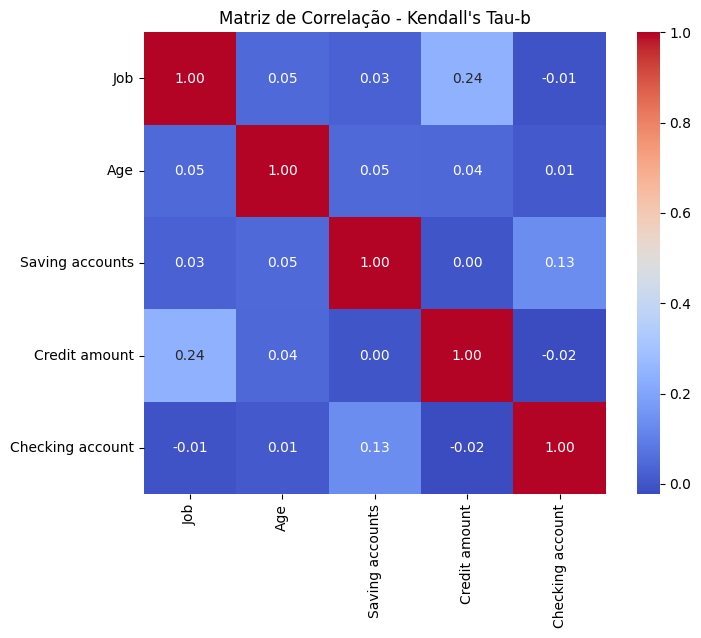

In [261]:
corr_matrix = X_train_variable_selection[['Job', 'Age', 'Saving accounts', 'Credit amount', 'Checking account']].corr(method='kendall')

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlação - Kendall's Tau-b")
plt.show()

In [262]:
from scipy import stats
res = stats.kendalltau(X_train_variable_selection[['Job']],X_train_variable_selection[['Credit amount']] , variant='b')
print('tau=b',res)

tau=b SignificanceResult(statistic=np.float64(0.24351991456467706), pvalue=np.float64(2.6169459724159506e-19))


Conclusão nenhuma variavel continua demonstrou ter redundância o maior valor de kendal tau b foi de 0.24

## ReliefF - tabela inteira

In [263]:
!pip install skrebate

In [264]:
X_train_variable_selection.head()

,Age,Credit amount,Duration,Saving accounts,Checking account,Job,Sex,Housing,Purpose
0,-1.084571,-0.721798,0.257194,0.000000,1.000000,1.0,male,own,car
1,-1.084571,-0.846553,-0.743643,0.216481,0.000000,2.0,male,own,car
2,1.618410,-0.928761,-1.244061,0.000000,0.530784,0.0,female,own,car
3,-0.299835,-0.144175,-0.910449,1.000000,0.856188,2.0,male,own,car
4,0.920867,1.579680,2.258868,0.216481,0.000000,3.0,male,own,business


In [265]:
from skrebate import ReliefF
import numpy as np
import pandas as pd
# X_array = np.array(X_train_variable_selection)
# Certifique-se de que y_train_resampled é um array (não uma Series com índice desalinhado)
y_array = np.array(y_train_transformed)
fs = ReliefF(n_neighbors=20)  # escolha n_features_to_keep conforme necessário
X_train_relief = fs.fit_transform(X_train_variable_selection_ohe.values, y_array)


In [266]:
feature_names = X_train_variable_selection_ohe.columns

# Scores calculados pelo ReliefF (já presente no objeto fs após o fit)
relief_scores = fs.feature_importances_

# Cria um DataFrame com os resultados
ranked_features = pd.DataFrame({
    'Feature': feature_names,
    'ReliefF_Score': relief_scores
})

# Ordena do mais importante para o menos importante
ranked_features = ranked_features.sort_values(by='ReliefF_Score', ascending=False).reset_index(drop=True)

# Exibe o ranking completo
ranked_features

,Feature,ReliefF_Score
0,Duration,0.076968
1,Checking account,0.058942
2,Credit amount,0.047737
3,Age,0.043850
4,Saving accounts,0.032301
5,Job,0.028631
6,Purpose_furniture/equipment,0.005762
7,Purpose_education,0.004382
8,Purpose_car,0.004142
9,Purpose_business,0.003842


In [267]:
# reliefF_df = pd.DataFrame({
#     'feature': X_train_variable_selection_ohe.columns,
#     'mi_score': mi_scores
# })


def extract_base_name(col):
    for prefix in ['Housing', 'Purpose', 'Sex']:
        if col.startswith(prefix):
            return prefix
    return col

ranked_features['Feature'] = ranked_features['Feature'].apply(extract_base_name)
ranked_features_aggregated = ranked_features.groupby('Feature')['ReliefF_Score'].sum().sort_values(ascending=False)



In [268]:
ranked_features_aggregated

,ReliefF_Score
Feature,
Duration,0.076968
Checking account,0.058942
Credit amount,0.047737
Age,0.043850
Saving accounts,0.032301
Job,0.028631
Purpose,0.022449
Housing,0.000540
Sex,-0.001321


In [269]:
ranked_features_aggregated.values

array([ 0.07696826,  0.05894175,  0.04773692,  0.04385031,  0.0323007 ,
        0.02863145,  0.02244898,  0.00054022, -0.00132053])

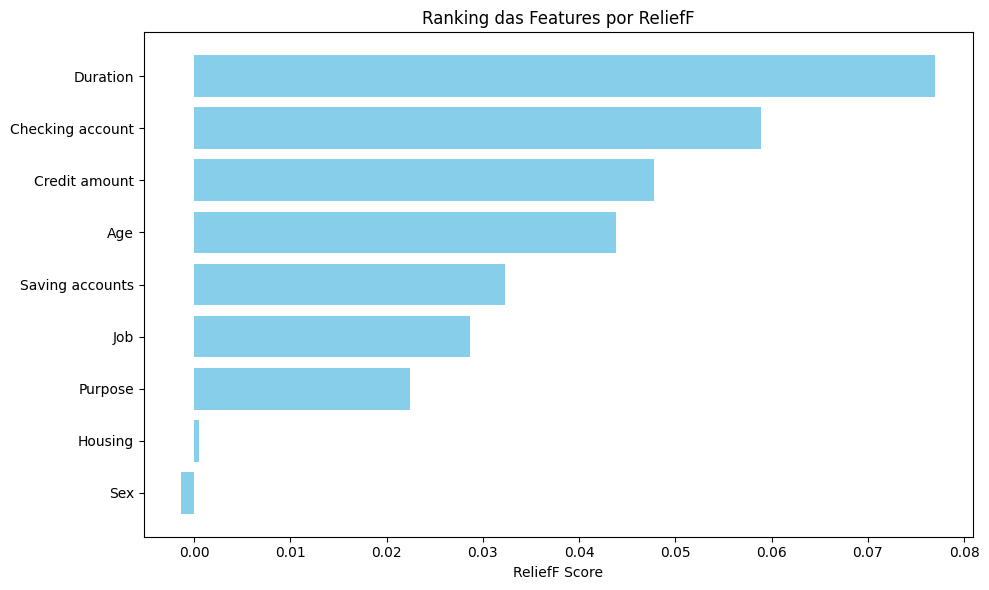

In [270]:
ranked_features_aggregated_sorted = ranked_features_aggregated.sort_values(ascending=True)

# Gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(ranked_features_aggregated_sorted.index, ranked_features_aggregated_sorted.values, color='skyblue')
plt.xlabel('ReliefF Score')
plt.title('Ranking das Features por ReliefF')
plt.tight_layout()
plt.show()

## Mutual information (MI) - tabela inteira

Assim como reliefF, MI tem a capacidade de lidar com variáveis categóricas e contínuas, para isso deve ser inserido no argumento discrete_features da funcão `mutual_info_classif` um vetor booleano onde é indicado os indices das variáveis categóricas como `True` e `False` as contínuas. Observe que coloquei como Fase

In [271]:
X_train_variable_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               833 non-null    float64
 1   Credit amount     833 non-null    float64
 2   Duration          833 non-null    float64
 3   Saving accounts   833 non-null    float64
 4   Checking account  833 non-null    float64
 5   Job               833 non-null    float64
 6   Sex               833 non-null    object 
 7   Housing           830 non-null    object 
 8   Purpose           824 non-null    object 
dtypes: float64(6), object(3)
memory usage: 58.7+ KB


In [272]:
X_train_variable_selection_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          833 non-null    float64
 1   Credit amount                833 non-null    float64
 2   Duration                     833 non-null    float64
 3   Saving accounts              833 non-null    float64
 4   Checking account             833 non-null    float64
 5   Sex_female                   833 non-null    float64
 6   Sex_male                     833 non-null    float64
 7   Housing_free                 833 non-null    float64
 8   Housing_own                  833 non-null    float64
 9   Housing_rent                 833 non-null    float64
 10  Purpose_business             833 non-null    float64
 11  Purpose_car                  833 non-null    float64
 12  Purpose_education            833 non-null    float64
 13  Purpose_furniture/eq

MI com a tabela com One Hot encode

In [273]:
from sklearn.feature_selection import mutual_info_classif
discrete_features = [False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True]

mi_scores = mutual_info_classif(X_train_variable_selection_ohe, y_train_transformed, discrete_features=discrete_features)

In [274]:
mi_scores

array([8.83269190e-02, 4.75503217e-02, 1.05340726e-01, 8.70219199e-02,
       1.08662193e-01, 2.58470660e-03, 2.58470660e-03, 4.33964876e-03,
       1.56956326e-02, 7.43575952e-03, 6.57989719e-05, 2.97337237e-03,
       6.82827803e-04, 8.82855130e-04, 8.07793093e-03, 1.01538370e-03,
       4.84905364e-04])

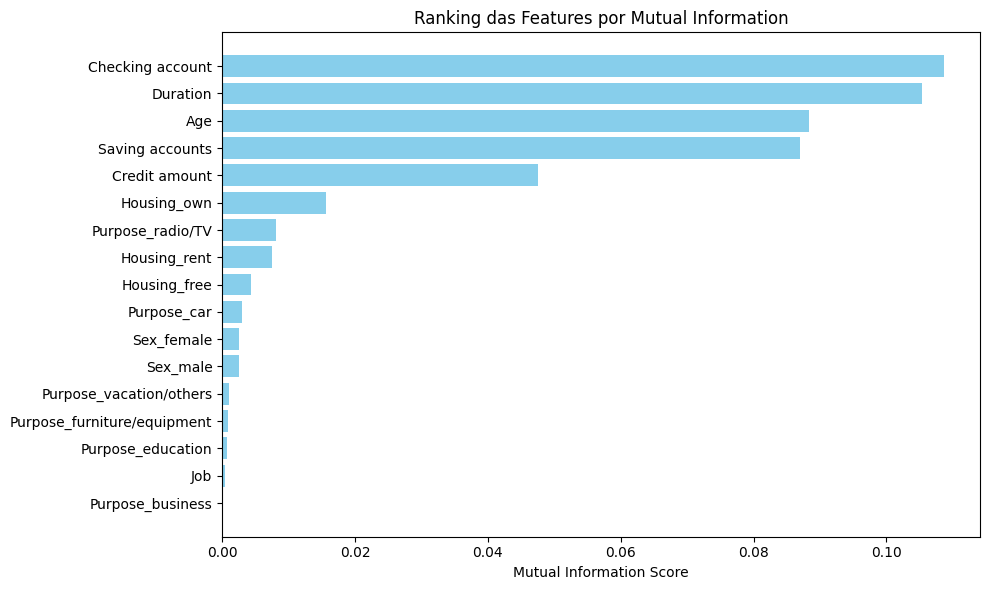

In [275]:
mi_df = pd.DataFrame({
    'Feature': X_train_variable_selection_ohe.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=True)  # Ordenar para gráfico

# Gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI_Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Ranking das Features por Mutual Information')
plt.tight_layout()
plt.show()

In [276]:

mi_df = pd.DataFrame({
    'feature': X_train_variable_selection_ohe.columns,
    'mi_score': mi_scores
})
mi_df

,feature,mi_score
0,Age,0.088327
1,Credit amount,0.047550
2,Duration,0.105341
3,Saving accounts,0.087022
4,Checking account,0.108662
5,Sex_female,0.002585
6,Sex_male,0.002585
7,Housing_free,0.004340
8,Housing_own,0.015696
9,Housing_rent,0.007436


Como os atributos estavam com oneHotEncode, para considerar um atributo só, somei os score de cada atributo. Apesar de aparentar ser um tratamento ineficaz para os atributos com OneHotEncode, assim como reliefF e chi quadrado, MI mostrou os 2 atributos que mais atrapalharam a base: Sex e Job

In [277]:

def extract_base_name(col):
    for prefix in ['Housing', 'Purpose', 'Sex']:
        if col.startswith(prefix):
            return prefix
    return col

mi_df['base_feature'] = mi_df['feature'].apply(extract_base_name)
aggregated = mi_df.groupby('base_feature')['mi_score'].sum().sort_values(ascending=False)

# aggregated

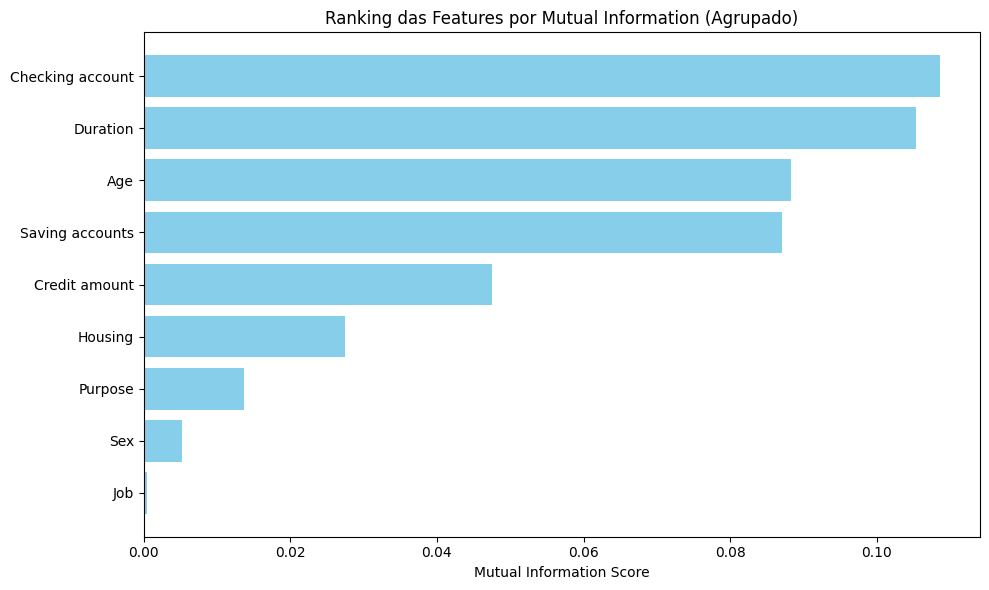

In [278]:
# Ordena do maior para o menor
aggregated_sorted = aggregated.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(aggregated_sorted.index, aggregated_sorted.values, color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Ranking das Features por Mutual Information (Agrupado)')
plt.tight_layout()
plt.show()


## Avaliacao das variaveis

### Tabela de Ranking das Features

| Método de seleção | chi quadrado( χ² ) | Mutual Information ( MI ) | ReliefF |
| :--- | :---: | :---: | :---: |
| **Age** | - | 3 | 4 |
| **Credit amount** | - | 5 | 3 |
| **Duration** | - | 2 | 1 |
| **Saving accounts** | - | 4 | 5 |
| **Checking account** | - | 1 | 2 |
| **Job** | 4 | 9 | 6 |
| **Sex** | 3 | 8 | 9 |
| **Housing** | 1 | 6 | 8 |
| **Purpose** | 2 | 7 | 7 |

Obs: Para kendall tau b usei um mapa de calor que esta no topico:
*Avaliando entre as variaveis de entrada continua - continua
Kendall tau b*. O mapa mostra que nas variaveis continuas e ordinais nao possuem nenhuma redundância, pois não apresenta uma correlação significativa (a maior foi de 0.24)


O Resultado mostra que os 2 piores atributos, são sem dúvidas Job e Sex, vamos testar agora o desempenho sem eles.

## Pipeline sem os 'piores' atributos
Irei testar 2 pipelines, 1 sem Job e outro sem Sex e avaliar
Se der tempo avaliar sem Job e sem Sex

### Pipeline sem Job

In [279]:
numeric_columns = ['Age', 'Credit amount', 'Duration']
ordinal_columns = ['Saving accounts', 'Checking account']
nominal_columns = ['Sex', 'Housing', 'Purpose']

X_train_grouped_without_Job = X_train_grouped.drop(columns=['Job'])
# X_train_grouped_without_Sex = X_train_grouped_without_Job.drop(columns=['Sex'])



In [280]:

numeric_pipeline = Pipeline([
  ('scaler', StandardScaler()),
])


iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=15, random_state=42),
    max_iter=15,
    random_state=42,
    initial_strategy='most_frequent'
)

categories_saving_accounts = ['little', 'moderate', 'quite rich', 'rich']
categories_checking_account = ['little', 'moderate', 'rich']

list_of_category_orders = [categories_saving_accounts, categories_checking_account]

ordinal_encoder_for_imputation = OrdinalEncoder(
    categories=list_of_category_orders,
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)



ordinal_pipeline = Pipeline([
    ('encoder', ordinal_encoder_for_imputation),
    ('imputer', iter_imputer),
])

ohe = OneHotEncoder(handle_unknown='ignore')

nominal_pipeline = Pipeline([
    ('encoder', ohe)
])

preprocessor_without_job = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('ord', ordinal_pipeline, ordinal_columns),
    ('nom', nominal_pipeline, nominal_columns),
])


In [281]:
numeric_columns

['Age', 'Credit amount', 'Duration']

In [282]:
ordinal_columns

['Saving accounts', 'Checking account']

In [283]:
nominal_columns

['Sex', 'Housing', 'Purpose']

In [284]:
X_train_grouped_without_Job.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 355 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    int64 
 1   Sex               800 non-null    object
 2   Housing           800 non-null    object
 3   Saving accounts   657 non-null    object
 4   Checking account  486 non-null    object
 5   Credit amount     800 non-null    int64 
 6   Duration          800 non-null    int64 
 7   Purpose           800 non-null    object
dtypes: int64(3), object(5)
memory usage: 56.2+ KB


In [285]:
import pandas as pd

X_transformed = preprocessor_without_job.fit_transform(X_train_grouped_without_Job)

num_cols = numeric_columns
ord_cols = ordinal_columns

nom_cols = preprocessor_without_job.named_transformers_['nom']['encoder'].get_feature_names_out(nominal_columns)

all_feature_names = list(num_cols) + list(ord_cols) + list(nom_cols)

X_processed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

X_processed_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          800 non-null    float64
 1   Credit amount                800 non-null    float64
 2   Duration                     800 non-null    float64
 3   Saving accounts              800 non-null    float64
 4   Checking account             800 non-null    float64
 5   Sex_female                   800 non-null    float64
 6   Sex_male                     800 non-null    float64
 7   Housing_free                 800 non-null    float64
 8   Housing_own                  800 non-null    float64
 9   Housing_rent                 800 non-null    float64
 10  Purpose_business             800 non-null    float64
 11  Purpose_car                  800 non-null    float64
 12  Purpose_education            800 non-null    float64
 13  Purpose_furniture/eq

In [286]:
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline_without_job = ImbPipeline([
    ('preprocess', preprocessor_without_job),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            # categorical_features=[3, 4, 5, 6, 7, 8],
            # categorical_features=[1, 2, 3, 4, 5, 8],
            categorical_features=[5,6,7,8,9,10,11,12,13,14,15],
            # categorical_features=[1,2,3,4,5,8]
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),

  ('clf', DecisionTreeClassifier(random_state=0))
])


from imblearn.pipeline import Pipeline


param_dist = {
    'clf__max_depth': [None, 3, 5, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy'],

    # IterativeImputer: se quiser otimizar junto
    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],

    # SMOTENC: número de vizinhos no oversampling
    'resample__smote__k_neighbors': [3, 5, 7]
}

search = RandomizedSearchCV(
    pipeline_without_job,
    param_distributions=param_dist,
    n_iter=100,
    scoring={
        'roc_auc': 'roc_auc',
        # 'f1': make_scorer(f1_score)
    },
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_grouped_without_Job, y_train)

print(search.best_params_)

X_test_group = X_test.copy()
X_test_group['Purpose'] = X_test_group['Purpose'].apply(agrupar_purpose)
X_test_group_without_job = X_test_group.drop(columns=['Job'])

best_model = search.best_estimator_
y_pred = best_model.predict(X_test_group_without_job)
y_proba = best_model.predict_proba(X_test_group_without_job)[:, 1]


f1 = f1_score(y_test, y_pred, pos_label='good')  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test, y_proba)

print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'resample__smote__k_neighbors': 5, 'preprocess__ord__imputer__max_iter': 10, 'preprocess__ord__imputer__estimator__n_estimators': 20, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': 5, 'clf__criterion': 'entropy'}
F1-score: 0.8123
ROC AUC: 0.7340


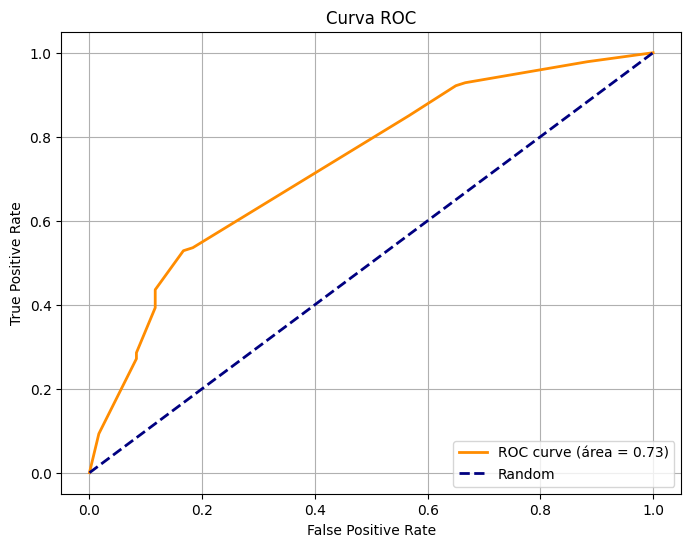

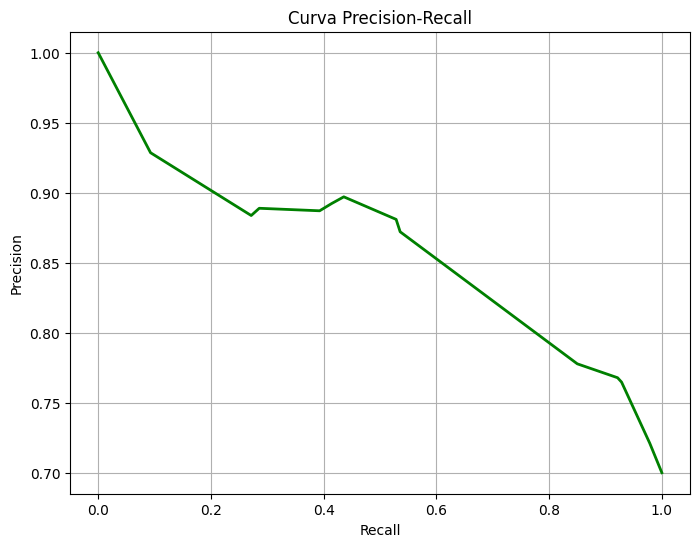

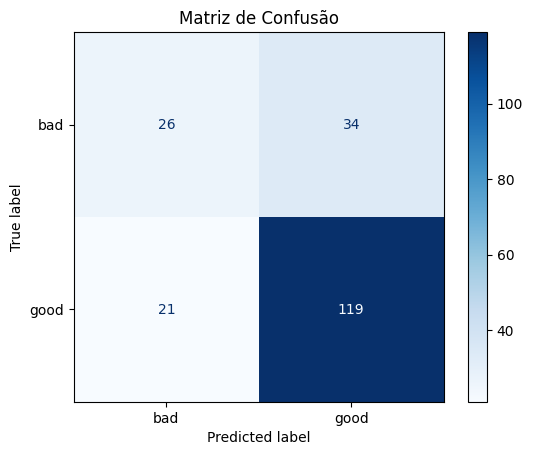

In [287]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = search.best_estimator_

y_proba = best_model.predict_proba(X_test_group_without_job)[:, 1]
y_pred = best_model.predict(X_test_group_without_job)

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

y_pred_numeric = np.where(y_pred == 'good', 1, 0)

cm = confusion_matrix(y_test_numeric, y_pred_numeric)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bad', 'good'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão')
plt.show()


### Pipeline sem Sex (melhor resultado)

In [288]:
numeric_columns = ['Age', 'Credit amount', 'Duration']
ordinal_columns = ['Saving accounts', 'Checking account']
nominal_columns = ['Housing', 'Purpose']


X_train_grouped_without_Sex = X_train_grouped.drop(columns=['Sex'])


In [289]:
numeric_pipeline = Pipeline([
  ('scaler', StandardScaler()),
])


iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=15, random_state=42),
    max_iter=15,
    random_state=42,
    initial_strategy='most_frequent'
)

categories_saving_accounts = ['little', 'moderate', 'quite rich', 'rich']
categories_checking_account = ['little', 'moderate', 'rich']

list_of_category_orders = [categories_saving_accounts, categories_checking_account]

ordinal_encoder_for_imputation = OrdinalEncoder(
    categories=list_of_category_orders,
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)

rounder = FunctionTransformer(lambda X: np.round(X), feature_names_out='one-to-one')



ordinal_pipeline = Pipeline([
    ('encoder', ordinal_encoder_for_imputation),
    ('imputer', iter_imputer),
])

ohe = OneHotEncoder(handle_unknown='ignore')

nominal_pipeline = Pipeline([
    ('encoder', ohe)
])

preprocessor_without_sex = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('ord', ordinal_pipeline, ordinal_columns),
    ('nom', nominal_pipeline, nominal_columns),
    ('Job', 'passthrough', ['Job'])

])


In [290]:
import pandas as pd

X_transformed = preprocessor_without_sex.fit_transform(X_train_grouped_without_Sex)

num_cols = numeric_columns
ord_cols = ordinal_columns

nom_cols = preprocessor_without_sex.named_transformers_['nom']['encoder'].get_feature_names_out(nominal_columns)

all_feature_names = list(num_cols) + list(ord_cols) + list(nom_cols) + ['Job']

X_processed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

X_processed_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          800 non-null    float64
 1   Credit amount                800 non-null    float64
 2   Duration                     800 non-null    float64
 3   Saving accounts              800 non-null    float64
 4   Checking account             800 non-null    float64
 5   Housing_free                 800 non-null    float64
 6   Housing_own                  800 non-null    float64
 7   Housing_rent                 800 non-null    float64
 8   Purpose_business             800 non-null    float64
 9   Purpose_car                  800 non-null    float64
 10  Purpose_education            800 non-null    float64
 11  Purpose_furniture/equipment  800 non-null    float64
 12  Purpose_radio/TV             800 non-null    float64
 13  Purpose_vacation/oth

In [291]:
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline_without_sex = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            # categorical_features=[3, 4, 5, 6, 7, 8],
            # categorical_features=[1, 2, 3, 4, 5, 8],
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            # categorical_features=[1,2,3,4,5,8]
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),

  ('clf', DecisionTreeClassifier(random_state=0))
])


from imblearn.pipeline import Pipeline


param_dist = {
    'clf__max_depth': [None, 3, 5, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy'],

    # IterativeImputer: se quiser otimizar junto
    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],

    # SMOTENC: número de vizinhos no oversampling
    'resample__smote__k_neighbors': [3, 5, 7]
}

search = RandomizedSearchCV(
    pipeline_without_sex,
    param_distributions=param_dist,
    n_iter=100,
    scoring={
        'roc_auc': 'roc_auc',
        # 'f1': make_scorer(f1_score)
    },
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_grouped_without_Sex, y_train)

print(search.best_params_)

X_test_group = X_test.copy()
X_test_group['Purpose'] = X_test_group['Purpose'].apply(agrupar_purpose)
X_test_group_without_Sex = X_test_group.drop(columns=['Sex'])

best_model = search.best_estimator_
y_pred = best_model.predict(X_test_group_without_Sex)
y_proba = best_model.predict_proba(X_test_group_without_Sex)[:, 1]


f1 = f1_score(y_test, y_pred, pos_label='good')  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test, y_proba)

print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'resample__smote__k_neighbors': 3, 'preprocess__ord__imputer__max_iter': 10, 'preprocess__ord__imputer__estimator__n_estimators': 5, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_depth': 5, 'clf__criterion': 'gini'}
F1-score: 0.8211
ROC AUC: 0.7583


In [292]:
y_train.head()

,Risk
355,bad
661,bad
300,good
916,good
294,good


### Pipeline sem Sex e sem Job

In [293]:
numeric_columns = ['Age', 'Credit amount', 'Duration']
ordinal_columns = ['Saving accounts', 'Checking account']
nominal_columns = ['Housing', 'Purpose']

X_train_grouped_without_Job = X_train_grouped.drop(columns=['Job'])
X_train_grouped_without_Sex_and_Job = X_train_grouped_without_Job.drop(columns=['Sex'])



In [294]:

numeric_pipeline = Pipeline([
  ('scaler', StandardScaler()),
])


iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=15, random_state=42),
    max_iter=15,
    random_state=42,
    initial_strategy='most_frequent'
)

categories_saving_accounts = ['little', 'moderate', 'quite rich', 'rich']
categories_checking_account = ['little', 'moderate', 'rich']

list_of_category_orders = [categories_saving_accounts, categories_checking_account]

ordinal_encoder_for_imputation = OrdinalEncoder(
    categories=list_of_category_orders,
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)

ordinal_pipeline = Pipeline([
    ('encoder', ordinal_encoder_for_imputation),
    ('imputer', iter_imputer),
])

ohe = OneHotEncoder(handle_unknown='ignore')

nominal_pipeline = Pipeline([
    ('encoder', ohe)
])

preprocessor_without_Sex_and_Job = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('ord', ordinal_pipeline, ordinal_columns),
    ('nom', nominal_pipeline, nominal_columns),
])


In [295]:
import pandas as pd

X_transformed = preprocessor_without_Sex_and_Job.fit_transform(X_train_grouped_without_Sex_and_Job)

num_cols = numeric_columns
ord_cols = ordinal_columns

nom_cols = preprocessor_without_Sex_and_Job.named_transformers_['nom']['encoder'].get_feature_names_out(nominal_columns)

all_feature_names = list(num_cols) + list(ord_cols) + list(nom_cols)

X_processed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

X_processed_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          800 non-null    float64
 1   Credit amount                800 non-null    float64
 2   Duration                     800 non-null    float64
 3   Saving accounts              800 non-null    float64
 4   Checking account             800 non-null    float64
 5   Housing_free                 800 non-null    float64
 6   Housing_own                  800 non-null    float64
 7   Housing_rent                 800 non-null    float64
 8   Purpose_business             800 non-null    float64
 9   Purpose_car                  800 non-null    float64
 10  Purpose_education            800 non-null    float64
 11  Purpose_furniture/equipment  800 non-null    float64
 12  Purpose_radio/TV             800 non-null    float64
 13  Purpose_vacation/oth

In [296]:
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline_without_Sex_and_Job = ImbPipeline([
    ('preprocess', preprocessor_without_Sex_and_Job),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            # categorical_features=[3, 4, 5, 6, 7, 8],
            # categorical_features=[1, 2, 3, 4, 5, 8],
            categorical_features=[5,6,7,8,9,10,11,12,13],
            # categorical_features=[1,2,3,4,5,8]
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),

  ('clf', DecisionTreeClassifier(random_state=0))
])


from imblearn.pipeline import Pipeline


param_dist = {
    'clf__max_depth': [None, 3, 5, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy'],

    # IterativeImputer: se quiser otimizar junto
    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],

    # SMOTENC: número de vizinhos no oversampling
    'resample__smote__k_neighbors': [3, 5, 7]
}

search = RandomizedSearchCV(
    pipeline_without_Sex_and_Job,
    param_distributions=param_dist,
    n_iter=100,
    scoring={
        'roc_auc': 'roc_auc',
        # 'f1': make_scorer(f1_score)
    },
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_grouped_without_Sex_and_Job, y_train)

print(search.best_params_)

X_test_group = X_test.copy()
X_test_group['Purpose'] = X_test_group['Purpose'].apply(agrupar_purpose)
X_test_group_without_Sex_and_Job = X_test_group.drop(columns=['Job'])

best_model = search.best_estimator_
y_pred = best_model.predict(X_test_group_without_Sex_and_Job)
y_proba = best_model.predict_proba(X_test_group_without_Sex_and_Job)[:, 1]


f1 = f1_score(y_test, y_pred, pos_label='good')  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test, y_proba)

print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'resample__smote__k_neighbors': 5, 'preprocess__ord__imputer__max_iter': 5, 'preprocess__ord__imputer__estimator__n_estimators': 10, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 3, 'clf__criterion': 'gini'}
F1-score: 0.7782
ROC AUC: 0.7227


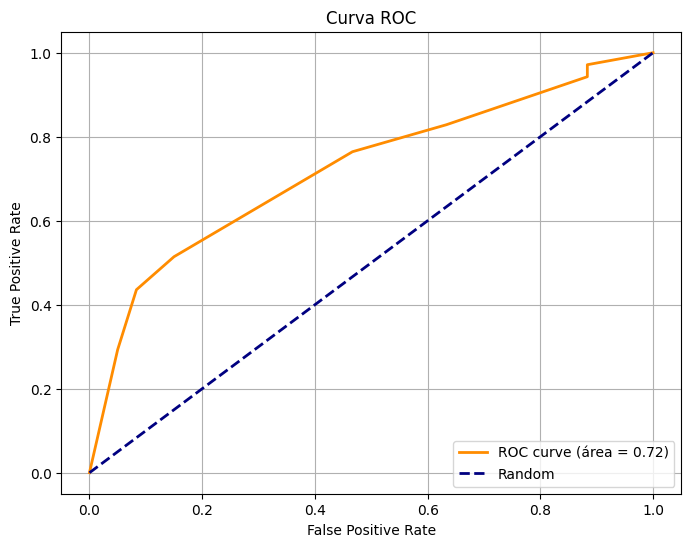

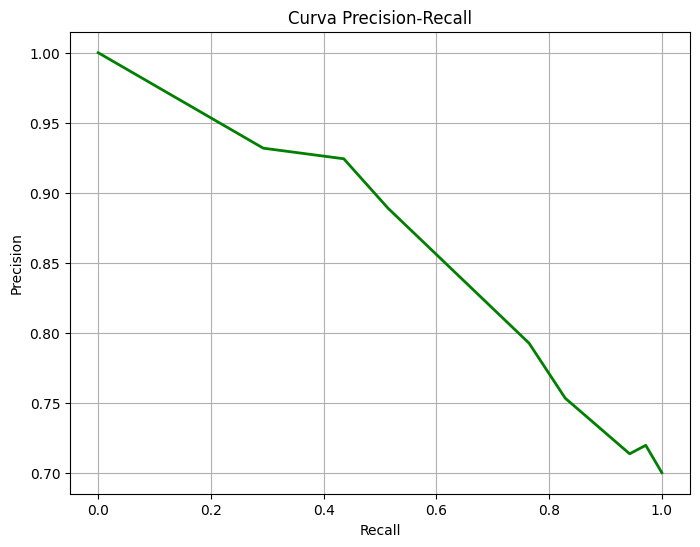

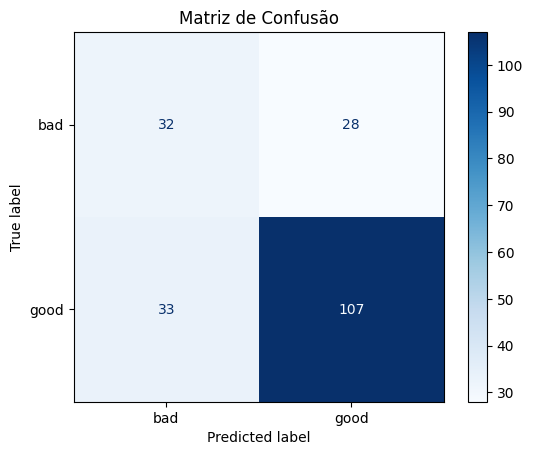

In [297]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = search.best_estimator_

y_proba = best_model.predict_proba(X_test_group_without_Sex_and_Job)[:, 1]
y_pred = best_model.predict(X_test_group_without_Sex_and_Job)

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

y_pred_numeric = np.where(y_pred == 'good', 1, 0)

cm = confusion_matrix(y_test_numeric, y_pred_numeric)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bad', 'good'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão')
plt.show()


## Qual a melhor seleção de variavel?
De acordo com o score de f1 e roc auc percebe-ce que o melhor resultado foi ao tirar o atributo Sex. Tirando ele conseguimos:

F1-score: 0.8211

ROC AUC: 0.7583

---
# Overview do pré processamento - Fim da parte 1 do trabalho



## 1. a)

| Atributo         | Tipo       | Escala  | Cardinalidade | Observações                     |
| ---------------- | ---------- | ------- | ------------- | ------------------------------- |
| Age              | Numérico   | Razão   | Contínua      | Idade do cliente em anos        |
| Duration              | Numérico   | Razão   | Contínua      | Em meses        |
| Credit amount             | Numérico   | Razão   | Contínua      | numeric, in DM       |
| Job              | Categórico | Ordinal | Discreta      | Níveis de emprego (0 a 3)       |
| Sex              | Categórico | Nominal | Binária       | 'male' ou 'female'              |
| Checking account | Categórico | Ordinal | Discreta      | 'little', 'moderate', 'rich', 'little rich' |
| Saving accounts  | Categórico | Ordinal | Discreta      | 'little', 'moderate', 'rich', 'little rich'           |
| Housing          | Categórico | Nominal | Discreta      | 'own', 'free', rent              |
| Purpose          | Categórico | Nominal | Discreta      | 'car', 'business', etc          |
| Risk (target)    | Categórico | Nominal | Binária       | 'good' ou 'bad'                 |


Mais informações sobre as variaveis:

Age (numeric)

Sex (text: male, female)

Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

Housing (text: own, rent, or free)

Saving accounts (text - little, moderate, quite rich, rich)

Checking account (numeric, in DM - Deutsch Mark)

Credit amount (numeric, in DM)

Duration (numeric, in month)

Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [313]:
#Valores unicos das variaveis categoricas
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"Coluna: {col}")
    print(X[col].unique())  # Valores únicos
    print("\n---\n")
print("Coluna: Job")
print(X_train['Job'].unique())

Coluna: Sex
['male' 'female']

---

Coluna: Housing
['own' 'free' 'rent']

---

Coluna: Saving accounts
[nan 'little' 'quite rich' 'rich' 'moderate']

---

Coluna: Checking account
['little' 'moderate' nan 'rich']

---

Coluna: Purpose
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']

---

Coluna: Job
[1 2 0 3]


## 1. b)

In [314]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 355 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    int64 
 1   Sex               800 non-null    object
 2   Job               800 non-null    int64 
 3   Housing           800 non-null    object
 4   Saving accounts   657 non-null    object
 5   Checking account  486 non-null    object
 6   Credit amount     800 non-null    int64 
 7   Duration          800 non-null    int64 
 8   Purpose           800 non-null    object
dtypes: int64(4), object(5)
memory usage: 62.5+ KB


In [315]:
X_train.describe()

,Age,Job,Credit amount,Duration
count,800.000000,800.000000,800.000000,800.000000
mean,35.438750,1.895000,3247.860000,20.916250
std,11.475991,0.645752,2775.170745,11.997465
min,19.000000,0.000000,276.000000,4.000000
25%,27.000000,2.000000,1363.250000,12.000000
50%,33.000000,2.000000,2281.500000,18.000000
75%,42.000000,2.000000,3965.250000,24.000000
max,75.000000,3.000000,15945.000000,72.000000


## 1. c)
**i.** Em limpeza de dados tentei aplicar remocao de outliers com iqr porém o resultado ficou relativamente pior, decidir não remove-los. Missing values eu preenchi com um iterative imputer com randomforest

<br>

**ii.** Normalização usei StandardScaler() para evitar problemas com escala dos numeros, com um possível KNNimputer ou classfier.

Usei também SMOTE NC - nominal and continuos para imputação de dados com tomek link para tirar variáveis da classe majoritaria. Como o balanceamento de 50-50 não teve resultado favorável optei por usar ≃ 60 - 40 das classes good e bad

Também fiz um agrupamento de 2 variaveis que praticamente não tinham ocorrência no dataset que poderia atrapalhar a arvore de decisão.

<br>

**iii**
Optei por nao fazer uma discretização porque isso nao afeta a arvore de decisão e nem os outros passos de pre processamento que eu fiz.

---
# Treinando outros modelos - Parte 2 do trabalho

A partir do melhor resultado usando decision tree como modelo para comparação entre os subprocessos do pré processamento, vamos analisar outros modelos de ML e no final avaliar qual teve o melhor resultado.

## Modelos essamble baseados em árvore

### XGBoost

In [298]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

pipeline_xgb = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss', # ou 'auc'
        use_label_encoder=False, # Adicionado para evitar warnings futuros
        random_state=42
    ))
])

param_dist_xgb = {
    # Parâmetros do XGBoost
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__subsample': [0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'clf__gamma': [0, 0.1, 0.5, 1],

    # Parâmetros do pré-processamento - imputer
    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],

    # Parâmetro do SMOTENC (mantido do exemplo anterior)
    'resample__smote__k_neighbors': [3, 5, 7]
}

# 4. Configurar e executar o RandomizedSearchCV
search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist_xgb,
    n_iter=100, # Você pode ajustar o número de iterações
    scoring='roc_auc', # Mantido refit='roc_auc'
    refit='roc_auc',
    cv=10, # Mantido cv=10
    random_state=42,
    n_jobs=-1,
    verbose=1
)

label_mapping = {'bad': 0, 'good': 1}

#Converta y_train e y_test
y_train_num = y_train.map(label_mapping)
y_test_num = y_test.map(label_mapping)

search_xgb.fit(X_train_grouped_without_Sex, y_train_num)

X_test_group = X_test.copy()
X_test_group['Purpose'] = X_test_group['Purpose'].apply(agrupar_purpose)
X_test_group_without_Sex = X_test_group.drop(columns=['Sex'])

best_model = search_xgb.best_estimator_
y_pred = best_model.predict(X_test_group_without_Sex)
y_proba = best_model.predict_proba(X_test_group_without_Sex)[:, 1]


f1 = f1_score(y_test_num, y_pred)  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test_num, y_proba)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:53:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [299]:
f1

0.8543046357615894

In [300]:
roc

np.float64(0.7739285714285714)

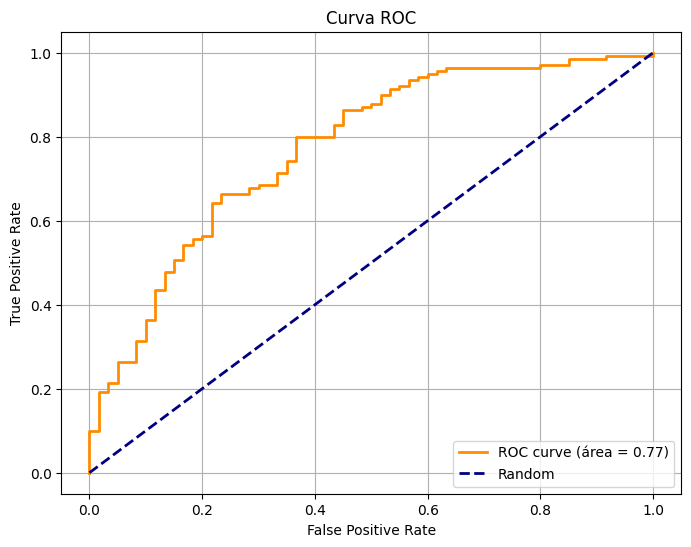

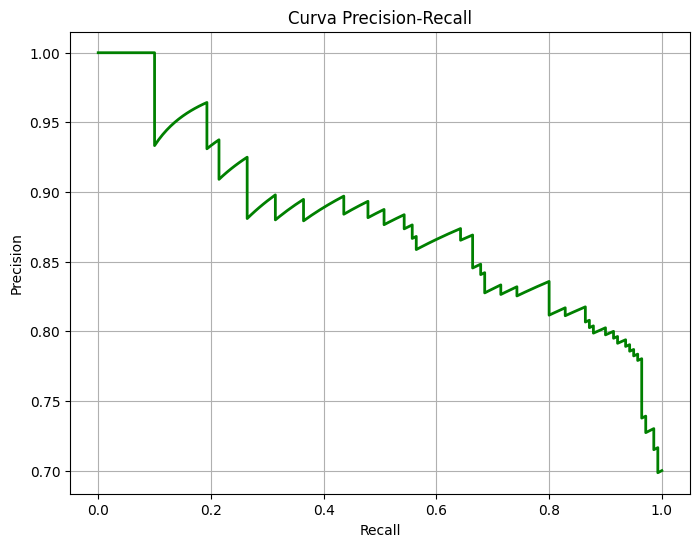

In [301]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = search_xgb.best_estimator_

y_proba = best_model.predict_proba(X_test_group_without_Sex)[:, 1]
y_pred = best_model.predict(X_test_group_without_Sex)

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

y_pred_numeric = np.where(y_pred == 'good', 1, 0)


Exibindo a Matriz de Confusão...


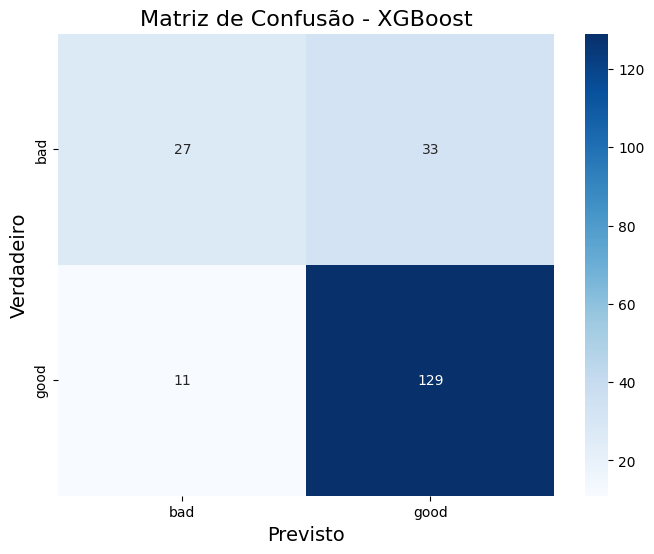

In [302]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = list(label_mapping.keys())

cm = confusion_matrix(y_test_num, y_pred)

print("Exibindo a Matriz de Confusão...")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('Matriz de Confusão - XGBoost', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()


### Ada Boost

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
470 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
470 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt

Melhores parâmetros para o AdaBoost:
{'resample__smote__k_neighbors': 7, 'preprocess__ord__imputer__max_iter': 10, 'preprocess__ord__imputer__estimator__n_estimators': 10, 'clf__n_estimators': 500, 'clf__learning_rate': 0.5, 'clf__algorithm': 'SAMME'}

Resultados do AdaBoost no conjunto de teste:
F1-score: 0.8311
ROC AUC: 0.8052

Exibindo a Matriz de Confusão para o AdaBoost...


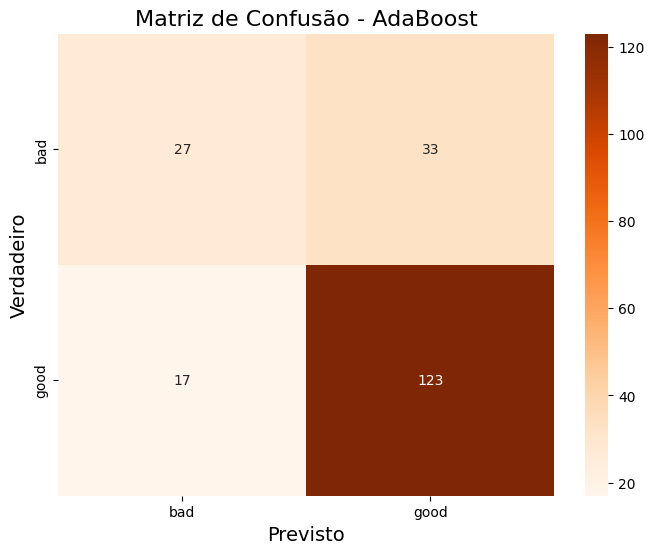

In [303]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

pipeline_ada = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', AdaBoostClassifier(random_state=42)) # <-- Trocamos por AdaBoost
])

param_dist_ada = {
    #Parâmetros do AdaBoost
    'clf__n_estimators': [50, 100, 200, 300, 500],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'clf__algorithm': ['SAMME', 'SAMME.R'],

    #Parâmetros do pré-processamento (mantidos para otimização conjunta)
    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],

    #Parâmetro do SMOTENC (mantido)
    'resample__smote__k_neighbors': [3, 5, 7]
}

search_ada = RandomizedSearchCV(
    pipeline_ada,
    param_distributions=param_dist_ada,
    n_iter=100,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_ada.fit(X_train_grouped_without_Sex, y_train_num)

print("Melhores parâmetros para o AdaBoost:")
print(search_ada.best_params_)

best_model_ada = search_ada.best_estimator_
y_pred_ada = best_model_ada.predict(X_test_group_without_Sex)
y_proba_ada = best_model_ada.predict_proba(X_test_group_without_Sex)[:, 1]

f1_ada = f1_score(y_test_num, y_pred_ada)
roc_ada = roc_auc_score(y_test_num, y_proba_ada)

print("\nResultados do AdaBoost no conjunto de teste:")
print(f"F1-score: {f1_ada:.4f}")
print(f"ROC AUC: {roc_ada:.4f}")

print("\nExibindo a Matriz de Confusão para o AdaBoost...")
cm_ada = confusion_matrix(y_test_num, y_pred_ada)
labels = list(label_mapping.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Oranges', # Mudei a cor para diferenciar
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - AdaBoost', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()

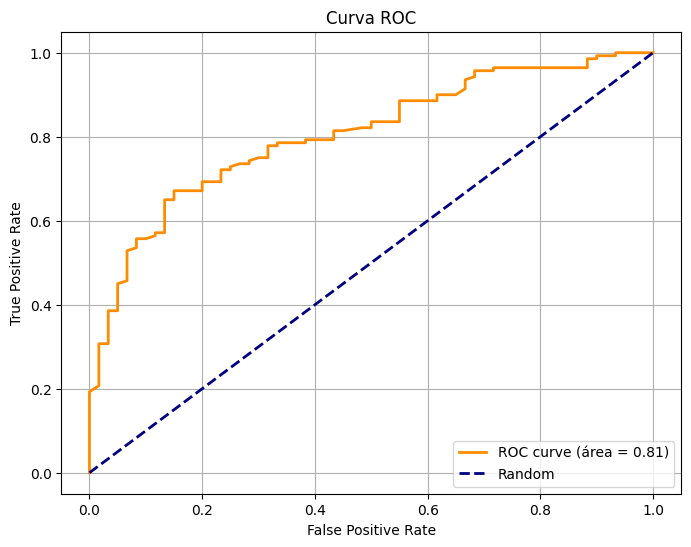

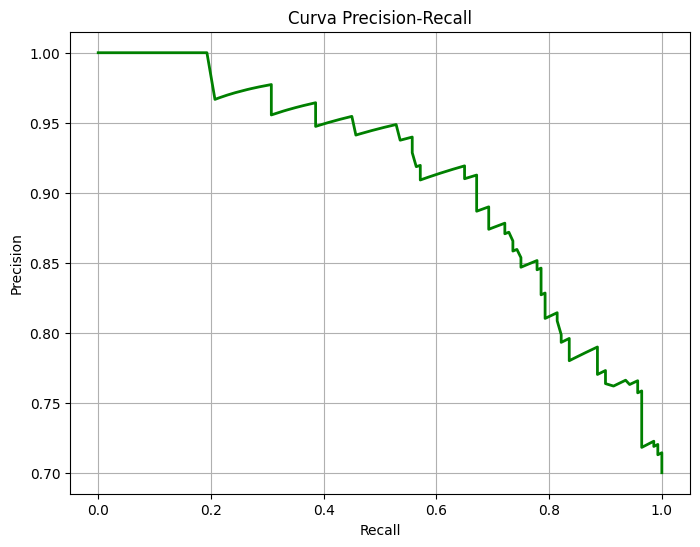

In [304]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = search_ada.best_estimator_

y_proba = best_model.predict_proba(X_test_group_without_Sex)[:, 1]
y_pred = best_model.predict(X_test_group_without_Sex)

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()



### Random Forest Classifier

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Melhores parâmetros para o RandomForest:
{'resample__smote__k_neighbors': 7, 'preprocess__ord__imputer__max_iter': 10, 'preprocess__ord__imputer__estimator__n_estimators': 5, 'clf__n_estimators': 300, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': None, 'clf__max_depth': 5, 'clf__criterion': 'gini'}

Resultados do RandomForest no conjunto de teste:
F1-score: 0.8618
ROC AUC: 0.7956

Exibindo a Matriz de Confusão para o RandomForest...


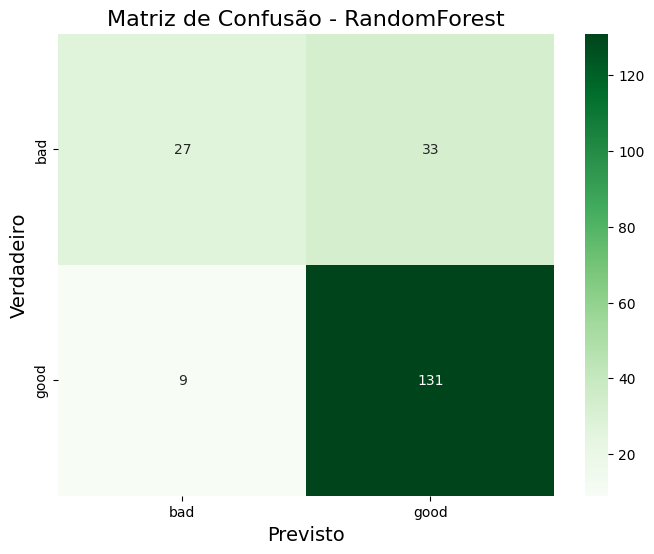

In [305]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_dist_rf = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_features': ['sqrt', 'log2', None],

    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],

    'resample__smote__k_neighbors': [3, 5, 7]
}

search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=100,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_rf.fit(X_train_grouped_without_Sex, y_train_num)

print("Melhores parâmetros para o RandomForest:")
print(search_rf.best_params_)

best_model_rf = search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test_group_without_Sex)
y_proba_rf = best_model_rf.predict_proba(X_test_group_without_Sex)[:, 1]

f1_rf = f1_score(y_test_num, y_pred_rf)
roc_rf = roc_auc_score(y_test_num, y_proba_rf)

print("\nResultados do RandomForest no conjunto de teste:")
print(f"F1-score: {f1_rf:.4f}")
print(f"ROC AUC: {roc_rf:.4f}")

print("\nExibindo a Matriz de Confusão para o RandomForest...")
cm_rf = confusion_matrix(y_test_num, y_pred_rf)
labels = list(label_mapping.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - RandomForest', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()

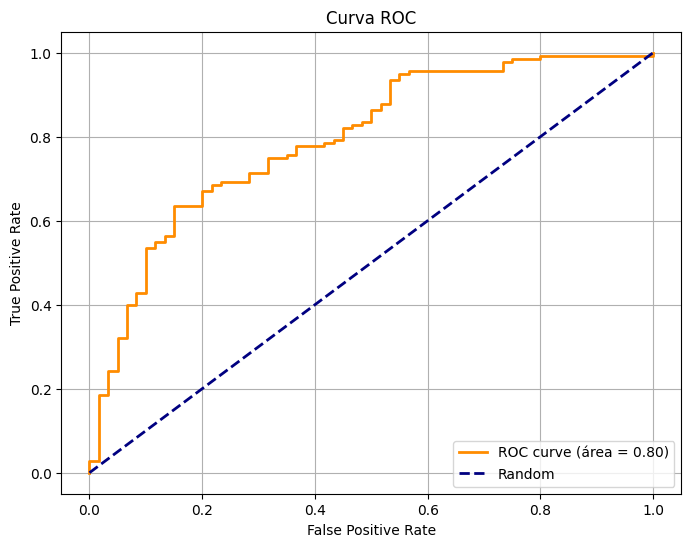

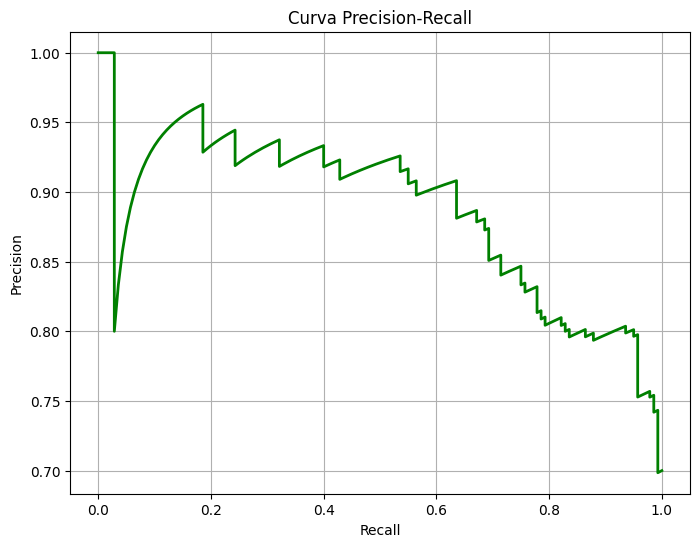

In [306]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = search_rf.best_estimator_

y_proba = best_model.predict_proba(X_test_group_without_Sex)[:, 1]
y_pred = best_model.predict(X_test_group_without_Sex)

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

y_pred_numeric = np.where(y_pred == 'good', 1, 0)


## Knn e Naive Bayes

### KNN

#### Para o knn vou usar um pipeline diferente, vou normalizar também os atributos ordinais.

In [307]:
numeric_columns = ['Age', 'Credit amount', 'Duration']
ordinal_columns = ['Saving accounts', 'Checking account']
nominal_columns = ['Housing', 'Purpose']


X_train_grouped_without_Sex = X_train_grouped.drop(columns=['Sex'])


In [308]:
numeric_pipeline = Pipeline([
  ('scaler', StandardScaler()),
])


iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=15, random_state=42),
    max_iter=15,
    random_state=42,
    initial_strategy='most_frequent'
)

categories_saving_accounts = ['little', 'moderate', 'quite rich', 'rich']
categories_checking_account = ['little', 'moderate', 'rich']

list_of_category_orders = [categories_saving_accounts, categories_checking_account]

ordinal_encoder_for_imputation = OrdinalEncoder(
    categories=list_of_category_orders,
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)


ordinal_pipeline = Pipeline([
    ('encoder', ordinal_encoder_for_imputation),
    ('imputer', iter_imputer),
    ('scaler', StandardScaler())
])

ohe = OneHotEncoder(handle_unknown='ignore')

nominal_pipeline = Pipeline([
    ('encoder', ohe)
])

preprocessor_to_knn = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('ord', ordinal_pipeline, ordinal_columns),
    ('nom', nominal_pipeline, nominal_columns),
    ('Job', 'passthrough', ['Job'])

])

from sklearn.neighbors import KNeighborsClassifier

pipeline_knn = ImbPipeline([
    ('preprocess', preprocessor_to_knn),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
  ('clf', KNeighborsClassifier(n_jobs=-1))
])



Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Melhores parâmetros para o KNN:
{'resample__smote__k_neighbors': 5, 'clf__weights': 'uniform', 'clf__n_neighbors': np.int64(29), 'clf__metric': 'euclidean'}

Resultados do KNN no conjunto de teste:
F1-score: 0.7762
ROC AUC: 0.6658


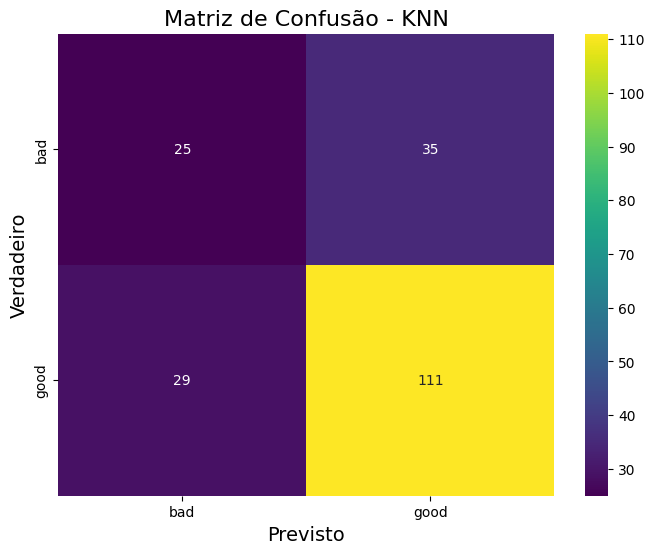

In [309]:
param_dist_knn = {
    'clf__n_neighbors': np.arange(3, 31, 2), # Testar diferentes valores de 'k'
    'clf__weights': ['uniform', 'distance'], # Testar diferentes pesos para os vizinhos
    'clf__metric': ['euclidean', 'manhattan', 'minkowski'], # Testar diferentes métricas de distância
    'resample__smote__k_neighbors': [3, 5, 7]
}

search_knn = RandomizedSearchCV(
    pipeline_knn,
    param_distributions=param_dist_knn,
    n_iter=100,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_knn.fit(X_train_grouped_without_Sex, y_train_num)


#Avaliação do melhor modelo KNN
print("\nMelhores parâmetros para o KNN:")
print(search_knn.best_params_)

best_model_knn = search_knn.best_estimator_
y_pred_knn = best_model_knn.predict(X_test_group_without_Sex)
y_proba_knn = best_model_knn.predict_proba(X_test_group_without_Sex)[:, 1]

f1_knn = f1_score(y_test_num, y_pred_knn)
roc_knn = roc_auc_score(y_test_num, y_proba_knn)

print("\nResultados do KNN no conjunto de teste:")
print(f"F1-score: {f1_knn:.4f}")
print(f"ROC AUC: {roc_knn:.4f}")

#Matriz de Confusão para o KNN
cm_knn = confusion_matrix(y_test_num, y_pred_knn)
labels = list(label_mapping.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - KNN', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()


#### Sem normalizar os ordinais:

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Melhores parâmetros para o KNN:
{'resample__smote__k_neighbors': 5, 'clf__weights': 'uniform', 'clf__n_neighbors': np.int64(29), 'clf__metric': 'euclidean'}

Resultados do KNN no conjunto de teste:
F1-score: 0.7746
ROC AUC: 0.6657


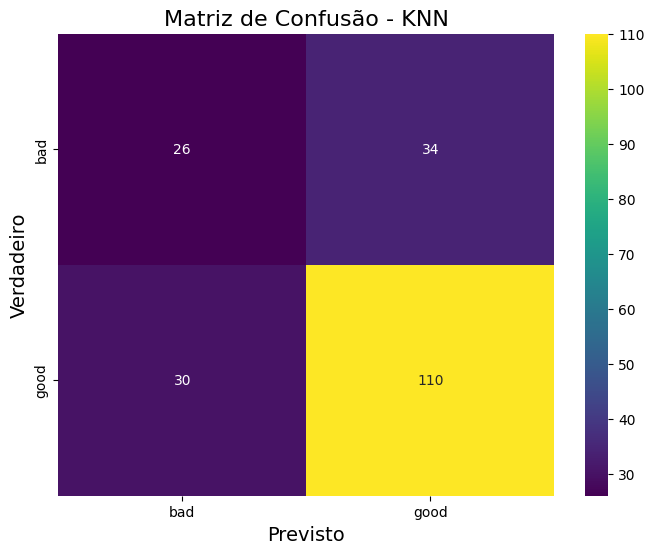

In [310]:
from sklearn.neighbors import KNeighborsClassifier


pipeline_knn = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', KNeighborsClassifier(n_jobs=-1)) # <-- Trocamos por KNN
])

param_dist_knn = {
    'clf__n_neighbors': np.arange(3, 31, 2), # Testar diferentes valores de 'k'
    'clf__weights': ['uniform', 'distance'], # Testar diferentes pesos para os vizinhos
    'clf__metric': ['euclidean', 'manhattan', 'minkowski'], # Testar diferentes métricas de distância

    # Mantemos o parâmetro do rebalanceamento
    'resample__smote__k_neighbors': [3, 5, 7]
}

search_knn = RandomizedSearchCV(
    pipeline_knn,
    param_distributions=param_dist_knn,
    n_iter=100,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_knn.fit(X_train_grouped_without_Sex, y_train_num)


#Avaliação do melhor modelo KNN
print("\nMelhores parâmetros para o KNN:")
print(search_knn.best_params_)

best_model_knn = search_knn.best_estimator_
y_pred_knn = best_model_knn.predict(X_test_group_without_Sex)
y_proba_knn = best_model_knn.predict_proba(X_test_group_without_Sex)[:, 1]

f1_knn = f1_score(y_test_num, y_pred_knn)
roc_knn = roc_auc_score(y_test_num, y_proba_knn)

print("\nResultados do KNN no conjunto de teste:")
print(f"F1-score: {f1_knn:.4f}")
print(f"ROC AUC: {roc_knn:.4f}")

#Matriz de Confusão para o KNN
cm_knn = confusion_matrix(y_test_num, y_pred_knn)
labels = list(label_mapping.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - KNN', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()

#### Conclusão: Normalizar os atributos ordinais trouxe um ganho desconsiderável

#### Knn com NCA

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
640 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_indexing.py", line 315, in _get_column_indices_for_bool_or_int
    idx = _safe_indexing(np.arange(n_columns), key)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_indexing.py", line 270, in _safe_indexing
    return _array_indexing(X, indices, indices_dtype, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/l


Melhores parâmetros para o KNN com NCA:
{'resample__smote__k_neighbors': 7, 'nca__n_components': None, 'clf__weights': 'uniform', 'clf__n_neighbors': np.int64(29), 'clf__metric': 'manhattan'}

Resultados do KNN com NCA no conjunto de teste:
F1-score: 0.8173
ROC AUC: 0.6802


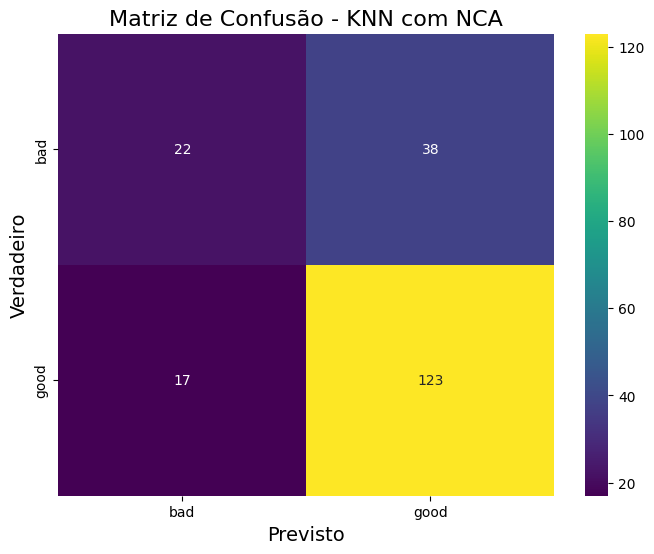

In [311]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis

pipeline_knn_nca = ImbPipeline([
    ('preprocess', preprocessor_to_knn),
    ('nca', NeighborhoodComponentsAnalysis(random_state=42)),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', KNeighborsClassifier(n_jobs=-1))
])

param_dist_knn_nca = {
    'nca__n_components': [None, 2, 5, 10, 15],  # None = manter dimensão original
    'clf__n_neighbors': np.arange(3, 31, 2),
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
    'resample__smote__k_neighbors': [3, 5, 7]
}

search_knn_nca = RandomizedSearchCV(
    pipeline_knn_nca,
    param_distributions=param_dist_knn_nca,
    n_iter=100,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_knn_nca.fit(X_train_grouped_without_Sex, y_train_num)

print("\nMelhores parâmetros para o KNN com NCA:")
print(search_knn_nca.best_params_)

best_model_knn_nca = search_knn_nca.best_estimator_
y_pred_knn_nca = best_model_knn_nca.predict(X_test_group_without_Sex)
y_proba_knn_nca = best_model_knn_nca.predict_proba(X_test_group_without_Sex)[:, 1]

f1_knn_nca = f1_score(y_test_num, y_pred_knn_nca)
roc_knn_nca = roc_auc_score(y_test_num, y_proba_knn_nca)

print("\nResultados do KNN com NCA no conjunto de teste:")
print(f"F1-score: {f1_knn_nca:.4f}")
print(f"ROC AUC: {roc_knn_nca:.4f}")

cm_knn_nca = confusion_matrix(y_test_num, y_pred_knn_nca)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn_nca, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - KNN com NCA', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()


### Naive bayes

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Melhores parâmetros para o Naive Bayes:
{'resample__smote__k_neighbors': 3, 'preprocess__ord__imputer__max_iter': 10, 'preprocess__ord__imputer__estimator__n_estimators': 10, 'clf__var_smoothing': np.float64(0.533669923120631)}

Resultados do Naive Bayes no conjunto de teste:
F1-score: 0.8027
ROC AUC: 0.6870


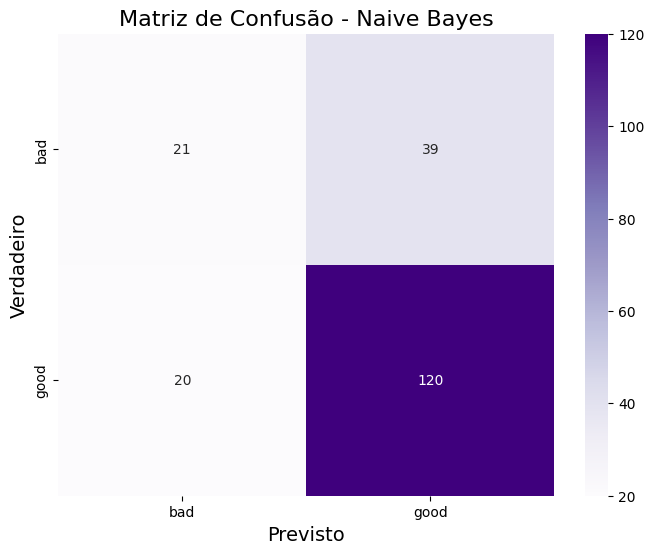

In [312]:
from sklearn.naive_bayes import GaussianNB

pipeline_nb = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', GaussianNB())
])

param_dist_nb = {
    'clf__var_smoothing': np.logspace(0, -9, num=100),

    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],
    'resample__smote__k_neighbors': [3, 5, 7]
}

search_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist_nb,
    n_iter=100,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_nb.fit(X_train_grouped_without_Sex, y_train_num)

print("\nMelhores parâmetros para o Naive Bayes:")
print(search_nb.best_params_)

best_model_nb = search_nb.best_estimator_
y_pred_nb = best_model_nb.predict(X_test_group_without_Sex)
y_proba_nb = best_model_nb.predict_proba(X_test_group_without_Sex)[:, 1]

f1_nb = f1_score(y_test_num, y_pred_nb)
roc_nb = roc_auc_score(y_test_num, y_proba_nb)

print("\nResultados do Naive Bayes no conjunto de teste:")
print(f"F1-score: {f1_nb:.4f}")
print(f"ROC AUC: {roc_nb:.4f}")

cm_nb = confusion_matrix(y_test_num, y_pred_nb)
labels = list(label_mapping.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - Naive Bayes', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()

---
# Tentando melhorar o desempenho a partir de modelos anteriores

## O que pode ser feito para tentar melhorar ROC e F1 score?
Uma tentativa de aumentar o desempenho do modelo seria:
- Aumentar o número de iterações para esses 2 modelos com maior desempenho (vale tentar também com XGBoost).
- Utilizar stacking a partir dos modelos anteriores para treinar.

## Stacking com random forest, XGBoost e ada boost:

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores parâmetros para o StackingClassifier:
{'resample__smote__k_neighbors': 5, 'preprocess__ord__imputer__max_iter': 15, 'preprocess__ord__imputer__estimator__n_estimators': 5, 'clf__xgb__n_estimators': 200, 'clf__xgb__max_depth': 7, 'clf__xgb__learning_rate': 0.3, 'clf__rf__n_estimators': 100, 'clf__rf__min_samples_split': 10, 'clf__rf__max_depth': 10, 'clf__final_estimator__n_estimators': 100, 'clf__final_estimator__max_depth': 3, 'clf__final_estimator__learning_rate': 0.03, 'clf__ada__n_estimators': 50, 'clf__ada__learning_rate': 0.5}

Resultados no conjunto de teste:
F1-score: 0.8163
ROC AUC: 0.7476


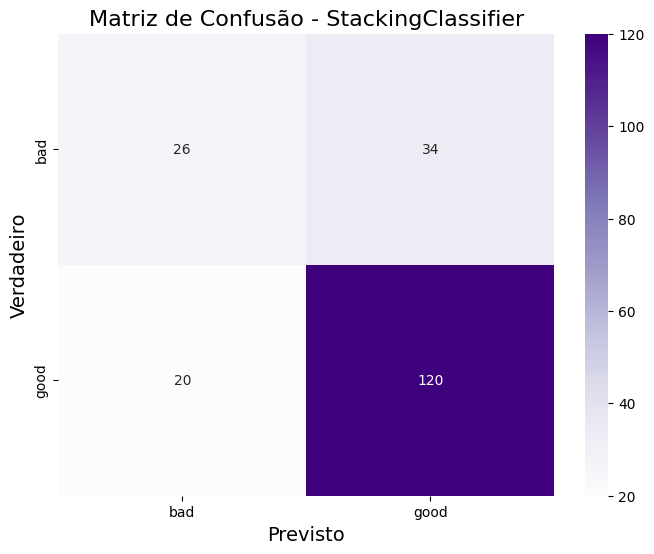

In [317]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# BASE MODELS
# -----------------------------
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# -----------------------------
# META-MODEL (XGBoost)
# -----------------------------
meta_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# -----------------------------
# STACKING CLASSIFIER
# -----------------------------
stacking = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    passthrough=True,
    n_jobs=-1
)

# -----------------------------
# PIPELINE COMPLETO
# -----------------------------
pipeline_stacking = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', stacking)
])

# -----------------------------
# PARAMETER DISTRIBUTION
# -----------------------------
param_dist_stacking = {
    # RandomForest
    'clf__rf__n_estimators': [100, 200],
    'clf__rf__max_depth': [None, 10, 20],
    'clf__rf__min_samples_split': [2, 5, 10],

    # AdaBoost
    'clf__ada__n_estimators': [50, 100, 200],
    'clf__ada__learning_rate': [0.05, 0.1, 0.5],

    # XGBoost (base)
    'clf__xgb__n_estimators': [100, 200],
    'clf__xgb__learning_rate': [0.05, 0.1, 0.3],
    'clf__xgb__max_depth': [3, 5, 7],

    # XGBoost (meta)
    'clf__final_estimator__n_estimators': [100, 200],
    'clf__final_estimator__learning_rate': [0.03, 0.1, 0.3],
    'clf__final_estimator__max_depth': [3, 5, 7],

    # SMOTENC
    'resample__smote__k_neighbors': [3, 5, 7],

    # Ordinal Imputer
    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20]
}

# -----------------------------
# RANDOMIZED SEARCH
# -----------------------------
search_stacking = RandomizedSearchCV(
    pipeline_stacking,
    param_distributions=param_dist_stacking,
    n_iter=100,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# -----------------------------
# FIT
# -----------------------------
search_stacking.fit(X_train_grouped_without_Sex, y_train_num)

# -----------------------------
# RESULTADOS
# -----------------------------
print("Melhores parâmetros para o StackingClassifier:")
print(search_stacking.best_params_)

best_model_stacking = search_stacking.best_estimator_

y_pred_stack = best_model_stacking.predict(X_test_group_without_Sex)
y_proba_stack = best_model_stacking.predict_proba(X_test_group_without_Sex)[:, 1]

f1_stack = f1_score(y_test_num, y_pred_stack)
roc_stack = roc_auc_score(y_test_num, y_proba_stack)

print("\nResultados no conjunto de teste:")
print(f"F1-score: {f1_stack:.4f}")
print(f"ROC AUC: {roc_stack:.4f}")

cm_stack = confusion_matrix(y_test_num, y_pred_stack)
labels = list(label_mapping.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - StackingClassifier', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()


## Como usar stacking nao ajudou, tentarei aumentar o número de iterações que dos melhores modelos (random forest, ada boost e XGBoost) de 100 para 200:

### RandomForestClassifier - 200 iterações

Fitting 10 folds for each of 200 candidates, totalling 2000 fits

Melhores parâmetros para o RandomForest:
{'resample__smote__k_neighbors': 7, 'preprocess__ord__imputer__max_iter': 10, 'preprocess__ord__imputer__estimator__n_estimators': 5, 'clf__n_estimators': 300, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': None, 'clf__max_depth': 5, 'clf__criterion': 'gini'}

Resultados do RandomForest no conjunto de teste:
F1-score: 0.8618
ROC AUC: 0.7956

Exibindo a Matriz de Confusão para o RandomForest...


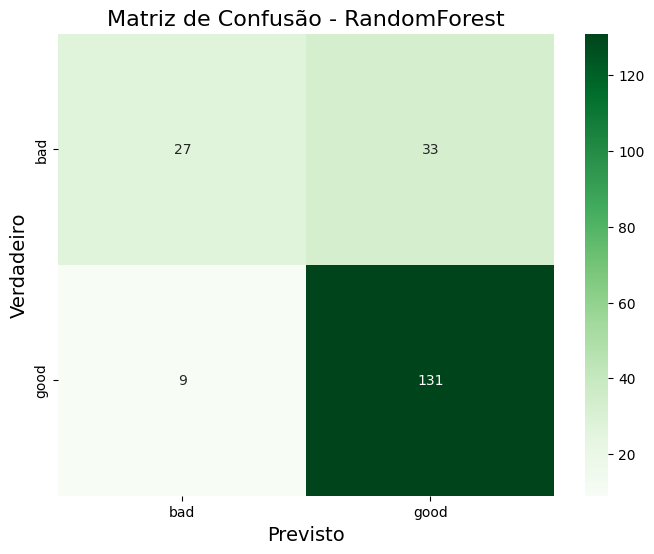

In [325]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix


pipeline_rf = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])


param_dist_rf = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_features': ['sqrt', 'log2', None],


    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],
    'resample__smote__k_neighbors': [3, 5, 7]
}

search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=200,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)


search_rf.fit(X_train_grouped_without_Sex, y_train_num)


print("\nMelhores parâmetros para o RandomForest:")
print(search_rf.best_params_)

best_model_rf = search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test_group_without_Sex)
y_proba_rf = best_model_rf.predict_proba(X_test_group_without_Sex)[:, 1]

f1_rf = f1_score(y_test_num, y_pred_rf)
roc_rf = roc_auc_score(y_test_num, y_proba_rf)

print("\nResultados do RandomForest no conjunto de teste:")
print(f"F1-score: {f1_rf:.4f}")
print(f"ROC AUC: {roc_rf:.4f}")

print("\nExibindo a Matriz de Confusão para o RandomForest...")
cm_rf = confusion_matrix(y_test_num, y_pred_rf)
labels = list(label_mapping.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - RandomForest', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()


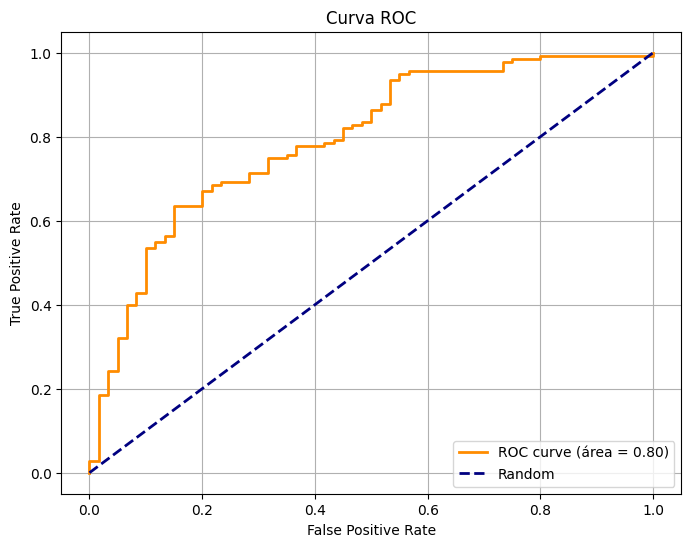

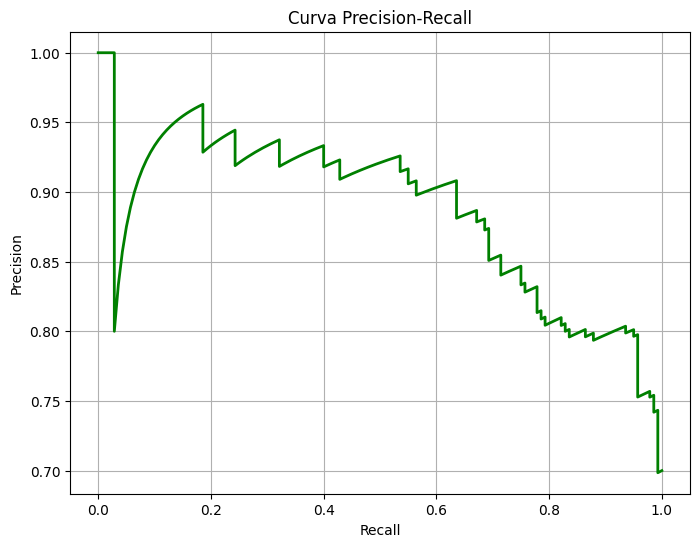

In [331]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = search_rf.best_estimator_

y_proba = best_model.predict_proba(X_test_group_without_Sex)[:, 1]
y_pred = best_model.predict(X_test_group_without_Sex)

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

y_pred_numeric = np.where(y_pred == 'good', 1, 0)

### Ada boost - 200 iterações

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1020 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1020 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, 

Melhores parâmetros para o AdaBoost:
{'resample__smote__k_neighbors': 7, 'preprocess__ord__imputer__max_iter': 15, 'preprocess__ord__imputer__estimator__n_estimators': 5, 'clf__n_estimators': 100, 'clf__learning_rate': 1.0, 'clf__algorithm': 'SAMME'}

Resultados do AdaBoost no conjunto de teste:
F1-score: 0.8328
ROC AUC: 0.8165

Exibindo a Matriz de Confusão para o AdaBoost...


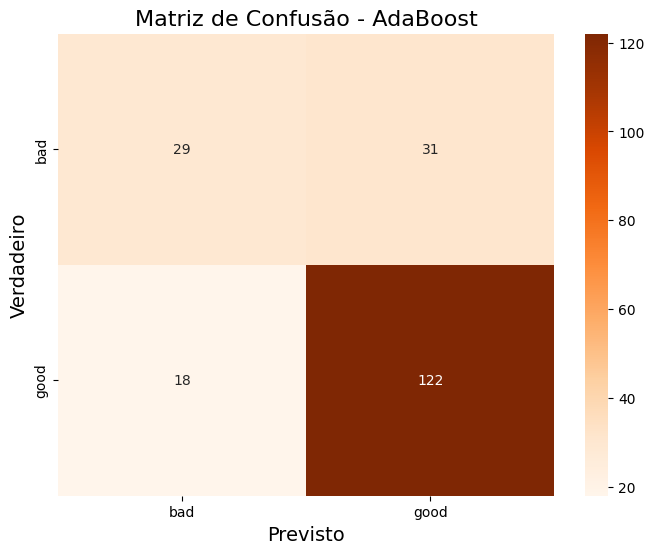

In [326]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

pipeline_ada = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', AdaBoostClassifier(random_state=42)) # <-- Trocamos por AdaBoost
])

param_dist_ada = {
    #Parâmetros do AdaBoost
    'clf__n_estimators': [50, 100, 200, 300, 500],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'clf__algorithm': ['SAMME', 'SAMME.R'],

    #Parâmetros do pré-processamento (mantidos para otimização conjunta)
    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],

    #Parâmetro do SMOTENC (mantido)
    'resample__smote__k_neighbors': [3, 5, 7]
}

search_ada = RandomizedSearchCV(
    pipeline_ada,
    param_distributions=param_dist_ada,
    n_iter=200,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_ada.fit(X_train_grouped_without_Sex, y_train_num)

print("Melhores parâmetros para o AdaBoost:")
print(search_ada.best_params_)

best_model_ada = search_ada.best_estimator_
y_pred_ada = best_model_ada.predict(X_test_group_without_Sex)
y_proba_ada = best_model_ada.predict_proba(X_test_group_without_Sex)[:, 1]

f1_ada = f1_score(y_test_num, y_pred_ada)
roc_ada = roc_auc_score(y_test_num, y_proba_ada)

print("\nResultados do AdaBoost no conjunto de teste:")
print(f"F1-score: {f1_ada:.4f}")
print(f"ROC AUC: {roc_ada:.4f}")

print("\nExibindo a Matriz de Confusão para o AdaBoost...")
cm_ada = confusion_matrix(y_test_num, y_pred_ada)
labels = list(label_mapping.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Oranges', # Mudei a cor para diferenciar
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - AdaBoost', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()

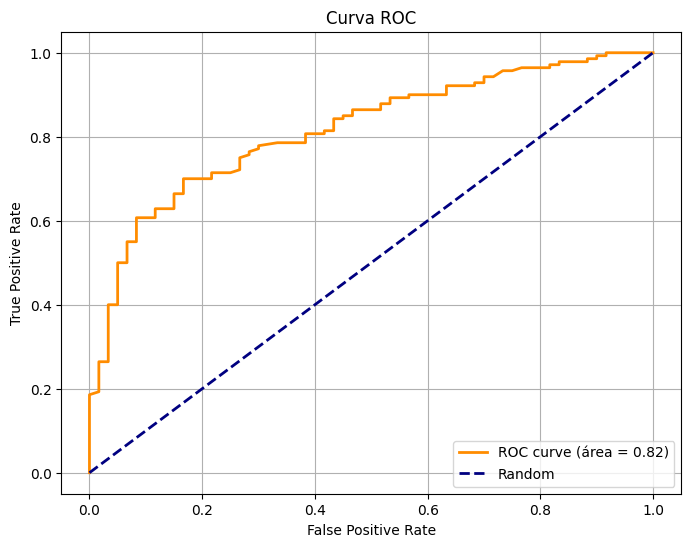

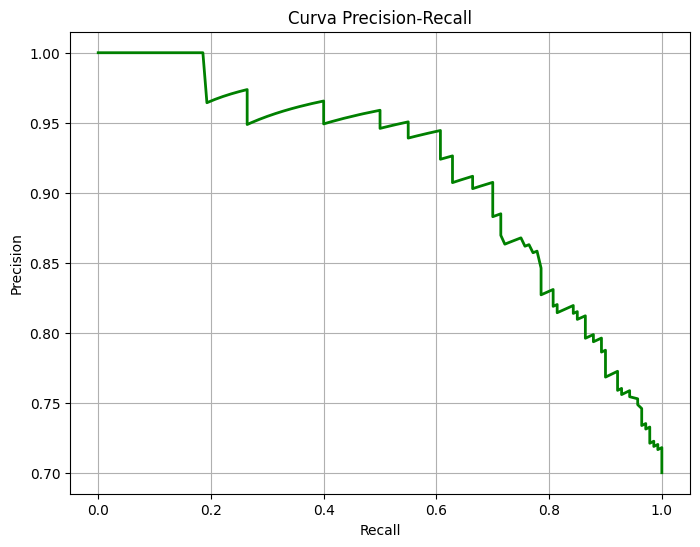

In [327]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = search_ada.best_estimator_

y_proba = best_model.predict_proba(X_test_group_without_Sex)[:, 1]
y_pred = best_model.predict(X_test_group_without_Sex)

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()



### XGBoost - 200 iterações

In [328]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

pipeline_xgb = ImbPipeline([
    ('preprocess', preprocessor_without_sex),
    ('resample', SMOTETomek(
        smote=SMOTENC(
            categorical_features=[5,6,7,8,9,10,11,12,13,14],
            sampling_strategy=0.6667,
            random_state=42
        ),
        random_state=42
    )),
    ('clf', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss', # ou 'auc'
        use_label_encoder=False, # Adicionado para evitar warnings futuros
        random_state=42
    ))
])

param_dist_xgb = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__subsample': [0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'clf__gamma': [0, 0.1, 0.5, 1],

    'preprocess__ord__imputer__max_iter': [5, 10, 15],
    'preprocess__ord__imputer__estimator__n_estimators': [5, 10, 20],

    'resample__smote__k_neighbors': [3, 5, 7]
}

search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist_xgb,
    n_iter=200,
    scoring='roc_auc',
    refit='roc_auc',
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

label_mapping = {'bad': 0, 'good': 1}

y_train_num = y_train.map(label_mapping)
y_test_num = y_test.map(label_mapping)

search_xgb.fit(X_train_grouped_without_Sex, y_train_num)

X_test_group = X_test.copy()
X_test_group['Purpose'] = X_test_group['Purpose'].apply(agrupar_purpose)
X_test_group_without_Sex = X_test_group.drop(columns=['Sex'])

best_model = search_xgb.best_estimator_
y_pred = best_model.predict(X_test_group_without_Sex)
y_proba = best_model.predict_proba(X_test_group_without_Sex)[:, 1]


f1 = f1_score(y_test_num, y_pred)  # ou 'bad', dependendo da sua classe positiva
roc = roc_auc_score(y_test_num, y_proba)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:33:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [332]:
f1

0.8599348534201955

In [333]:
roc

np.float64(0.7708333333333334)

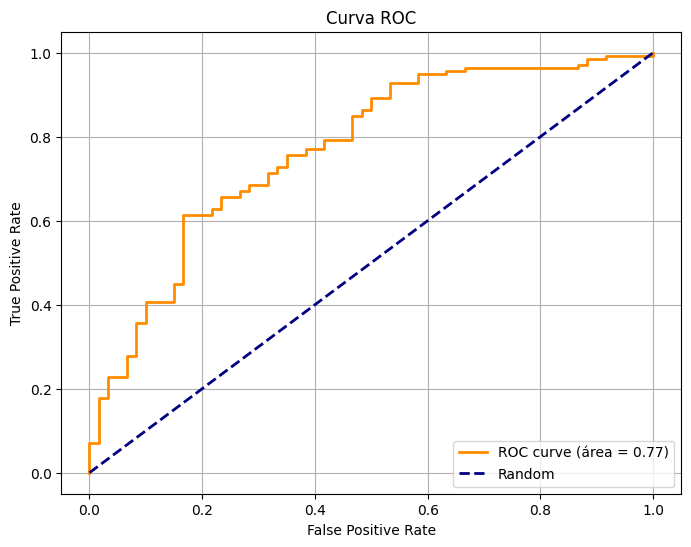

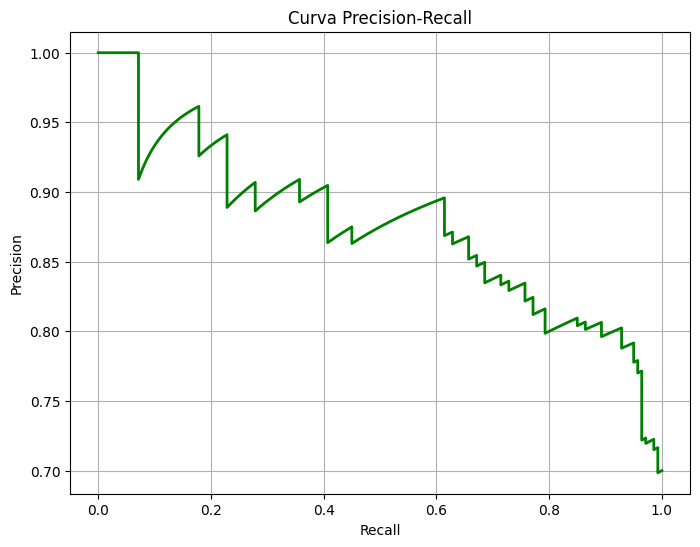

In [329]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = search_xgb.best_estimator_

y_proba = best_model.predict_proba(X_test_group_without_Sex)[:, 1]
y_pred = best_model.predict(X_test_group_without_Sex)

y_test_numeric = y_test.apply(lambda x: 1 if x == 'good' else 0)

fpr, tpr, threshold = roc_curve(y_test_numeric, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(y_test_numeric, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

y_pred_numeric = np.where(y_pred == 'good', 1, 0)


Exibindo a Matriz de Confusão...


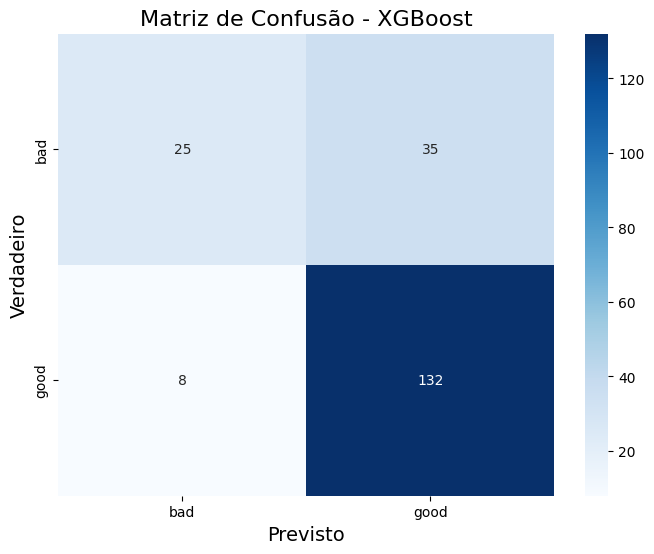

In [330]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = list(label_mapping.keys())

cm = confusion_matrix(y_test_num, y_pred)

print("Exibindo a Matriz de Confusão...")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('Matriz de Confusão - XGBoost', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=14)
plt.xlabel('Previsto', fontsize=14)
plt.show()


---
# Conclusão

Temos 2 modelos que tiveram os melhores resultados baseado no f1 score e ROC

- **Ada boost:**
 - **F1-score: 0.8328**
 - **ROC AUC: 0.8165**

- **Random forest**
 - **F1-score: 0.8618**
 - **ROC AUC: 0.7956**


### **O que foi feito no dataset:**

para os melhores resultados encontrados o processo que fiz foi:


- **Não removi outliers.**

- **Normalização dos dados numéricos.**

- **No atributo purpose com intuito de aumentar as ocorrências dos valores únicos que menos ocorriam:**
 - 'domestic appliances' em 'furniture/equipment'
 - 'repairs' em 'other'

- **Smote + tomek link com proporção 60%-40%**

- **Remoção do atributo 'Sex' que prejudicava o modelo base (arvore de decisão)**

- **Treinamento.**

obs: O agrupamento não é sem sentido, Domestic appliances ⊂ equipment (appliances são um subconjunto de equipments). Assim como 'others' contém 'repairs'.

### **Possíveis alterartivas para aumentar f1 score e roc:**

Ambos ada boost e random forest tiveram um resultado relativamente bons.

<br>

 Aumentar o número de iterações de RandomizedGridSearchCV não parece que terá um aumento significativo para XGBoost e random forest o melhor resultado foi encontrado com 100 iterações para ada boost talvez seria algo bom, pois ao mudar de 100 iterações para 200 tivemos um aumento de 1% de ROC.

<br>

Vale salientar que tentei exaustivamente buscar uma configuração de stacking alterando meta modelos e modelos base, porém não encontrei resultados melhores que ada boost e random forest. Além disso, o processo de treinar um modelo com stacking é muito demorado, portanto seria mais complicado de buscar um resultado melhor com esse tipo de essamble.

<br>

Alternativas plausíveis para melhor desempenho:
 - Aumentar número de iterações em RandomizedGridSearchCV para ada boost
 - Alterar hiperparâmetros de random forest e XGBoost.
 - aumentar o hiperparâmetros do smote.
